# Application and Evaluation of Machine Learning Models in Credit Scoring: Enhancing Predictive Accuracy and Interpretability

## Authors
- Bartosz Sobczak, s191690
- Jan Dzięcielski, s191702
- Szymon Oryńczak, s191722

## Introduction

This notebook presents the implementation and evaluation of three different machine learnings techniques for estimating credit scoring - Logistic Regression (specific version of it), Gradient Boosting (specific version of it) and Neural Network.

The results of the evaluations will be further analyzed and compared to the expected outcomes.

The notebook follows a structured approach, starting with the Exploration of a Dataset, and continuing with Data Preparation, Feature Engineering, Modeling, Evaluation, Interpretability and Summary.

Each section is accompanied by details explanations to facilitate an understanding of the underlying processes.

Necessary imports:

In [1]:
import pandas as pd
from IPython.display import display, HTML
import textwrap
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import plotly.express as px
from ydata_profiling import ProfileReport
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, make_scorer, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, precision_recall_fscore_support
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, RobustScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Activation, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
import optuna
import os, shutil, sys
import keras_tuner as kt
from lime.lime_tabular import LimeTabularExplainer
from collections import defaultdict
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

## Exploration of a Dataset

A dataset was provided by BIK (Biuro Informacji Kredytowej) - the largest credit bureau in Poland and a primary source of information on the liabilities of consumers and businesses in the country.

The delivered dataset consists of 24432 rows and 47 columns. The columns are describes in the documentation received from BIK.

<b>Below is the presentation of five random rows from raw .csv file:</b>

In [2]:
df = pd.read_csv("credit-data-bik.csv", encoding='cp1250')
display(HTML(df.head().to_html()))

,ID,ILE_BANKOW,ILE_BANKOW_12,ILE_MIES_OD_NAJSTAR_OTW,ILE_MIES_OD_NAJSTAR_OTW_NRAT,ILE_MIES_OD_NAJSTAR_OTW_RAT,ILE_PRODUKTOW,ILE_RACH_OTW,ILE_RACH_OTW_12,ILE_RACH_OTW_NRAT,ILE_RACH_OTW_NRAT_12,ILE_RACH_OTW_RAT,ILE_RACH_OTW_RAT_12,ILE_RACH_OTW_BEZ_HIPO,ILE_RACH_OTW_KARTY,ILE_RACH_OTW_ODNAWIALNE,ILE_RACH_ZAMK,ILE_ZAPYTAN_12,ILE_ZAPYTAN_3,ILE_ZAPYTAN_6,ILE_ZAPYTAN_9,L_RACHUNKOW,MAX_NAL_WYMAGAL,MAX_RATA,MAX_WNIOSKODAWCY,MIN_L_RAT_DO_SPLATY,SUMA_DO_SPLATY,SUMA_DO_SPLATY_BEZ_HIPO,SUMA_DO_SPLATY_KARTY,SUMA_DO_SPLATY_NRAT,SUMA_DO_SPLATY_ODNAWIALNE,SUMA_DO_SPLATY_RAT,SUMA_LIMIT,SUMA_LIMIT_KARTY,SUMA_LIMIT_ODNAWIALNE,SUMA_NAL_WYMAGAL,SUMA_NAL_WYMAGAL_BEZ_HIPO,SUMA_NAL_WYMAGAL_KARTY,SUMA_NAL_WYMAGAL_NRAT,SUMA_RATA,STATUS,TERYT,WOJEWODZTWO,POWIAT,GMINA,WIEK,PLEC
0,10474,1,1,"3,23","3,23",-99000792,1,1,1,1,1,0,0,1,0,1,0,1,0,1,1,1,0,-1,1,-99000792,56,56,-99000792,56,56,-99000792,464,-99000792,464,0,0,-99000792,0,0,1,142707,MAZOWIECKIE,SIERPECKI,ZAWIDZ,19,M
1,12863,1,1,"80,42","80,42","18,19",2,2,0,1,0,1,0,2,1,0,1,1,1,1,1,3,75,264,1,6,1629,1629,75,75,-99000792,1554,500,500,-99000792,75,75,75,75,264,1,142905,MAZOWIECKIE,SOKOďż˝OWSKI,KOSďż˝W LACKI,27,M
2,24208,3,-99000792,"34,39",-99000792,"34,39",1,3,0,0,0,3,0,3,0,0,5,-99000792,-99000792,-99000792,-99000792,8,1535,99,1,6,2365,2365,-99000792,-99000792,-99000792,2365,-99000792,-99000792,-99000792,2365,2365,-99000792,-99000792,99,2,280703,WARMIďż˝SKO-MAZURSKIE,Iďż˝AWSKI,Iďż˝AWA,25,M
3,21202,1,-99000792,"39,23","39,23","35,52",2,2,0,1,0,1,0,2,1,0,3,-99000792,-99000792,-99000792,-99000792,5,2299,0,1,-99000792,3332,3332,1033,1033,-99000792,2299,1000,1000,-99000792,3332,3332,1033,1033,0,2,81202,LUBUSKIE,WSCHOWSKI,SZLICHTYNGOWA,27,M
4,10179,1,1,"2,06",-99000792,"2,06",1,1,1,0,0,1,1,1,0,0,0,1,1,1,1,1,0,649,2,51,33118,33118,-99000792,-99000792,-99000792,33118,-99000792,-99000792,-99000792,0,0,-99000792,-99000792,649,1,101604,ďż˝ďż˝DZKIE,TOMASZOWSKI,CZERNIEWICE,36,K


### Default Distinction into Samples

The data is split into three samples:
- "good" clients (9637)
- undefined clients (9753)
- "bad" clients (5041)

This distinction is determined by the "STATUS" column: 0 indicates a "good" client, 1 an undefined client, and 2 a "bad" client.

In [3]:
df_status_counts = df.groupby("STATUS").size().reset_index(name="count")
display(HTML(df_status_counts.to_html(index=False)))

STATUS,count
0,9637
1,9753
2,5041


### Dataset Overview

A list of column features including: the column name, data type, number of not-null values, number of null values, number of unique values, memory usage in bytes, and an example value.

In [4]:
df_info = pd.DataFrame({
    "column": df.columns,
    "dtype": df.dtypes.values,
    "non_null": df.notnull().sum().values,
    "null": df.isnull().sum().values,
    "unique": df.nunique(dropna=True).values,
    "memory_bytes": df.memory_usage(deep=True, index=False).values, # deep - includes full python-level memory introspection, index=False - as the result returned Series has one element
    "example": [df[col].dropna().iloc[0] if df[col].notna().any() else None for col in df.columns] # first non-null value from the dropna() result or None if all are null
})

df_info.index = range(1, len(df_info) + 1) # start index from 1 
html = df_info.to_html(classes="df-info", border=0) # no border
scrollable = f'<div style="max-height:420px; overflow:auto; border:1px solid #ddd; padding:6px;">{html}</div>' # scrollable div
display(HTML(scrollable))

,column,dtype,non_null,null,unique,memory_bytes,example
1,ID,int64,24431,0,24431,195448,10474
2,ILE_BANKOW,int64,24431,0,10,195448,1
3,ILE_BANKOW_12,int64,24431,0,17,195448,1
4,ILE_MIES_OD_NAJSTAR_OTW,object,24431,0,5631,1323471,"3,23"
5,ILE_MIES_OD_NAJSTAR_OTW_NRAT,object,24431,0,5381,1355469,"3,23"
6,ILE_MIES_OD_NAJSTAR_OTW_RAT,object,24431,0,3698,1339179,-99000792
7,ILE_PRODUKTOW,int64,24431,0,7,195448,1
8,ILE_RACH_OTW,int64,24431,0,25,195448,1
9,ILE_RACH_OTW_12,int64,24431,0,20,195448,1
10,ILE_RACH_OTW_NRAT,int64,24431,0,11,195448,1


In [5]:
display(HTML(df.describe(include='all').to_html(float_format='{:,.0f}'.format)))

,ID,ILE_BANKOW,ILE_BANKOW_12,ILE_MIES_OD_NAJSTAR_OTW,ILE_MIES_OD_NAJSTAR_OTW_NRAT,ILE_MIES_OD_NAJSTAR_OTW_RAT,ILE_PRODUKTOW,ILE_RACH_OTW,ILE_RACH_OTW_12,ILE_RACH_OTW_NRAT,ILE_RACH_OTW_NRAT_12,ILE_RACH_OTW_RAT,ILE_RACH_OTW_RAT_12,ILE_RACH_OTW_BEZ_HIPO,ILE_RACH_OTW_KARTY,ILE_RACH_OTW_ODNAWIALNE,ILE_RACH_ZAMK,ILE_ZAPYTAN_12,ILE_ZAPYTAN_3,ILE_ZAPYTAN_6,ILE_ZAPYTAN_9,L_RACHUNKOW,MAX_NAL_WYMAGAL,MAX_RATA,MAX_WNIOSKODAWCY,MIN_L_RAT_DO_SPLATY,SUMA_DO_SPLATY,SUMA_DO_SPLATY_BEZ_HIPO,SUMA_DO_SPLATY_KARTY,SUMA_DO_SPLATY_NRAT,SUMA_DO_SPLATY_ODNAWIALNE,SUMA_DO_SPLATY_RAT,SUMA_LIMIT,SUMA_LIMIT_KARTY,SUMA_LIMIT_ODNAWIALNE,SUMA_NAL_WYMAGAL,SUMA_NAL_WYMAGAL_BEZ_HIPO,SUMA_NAL_WYMAGAL_KARTY,SUMA_NAL_WYMAGAL_NRAT,SUMA_RATA,STATUS,TERYT,WOJEWODZTWO,POWIAT,GMINA,WIEK,PLEC
count,"24,431","24,431","24,431",24431,24431,24431,"24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431",24431,24431,"24,431","24,431",24431,24431,"24,431","24,431","24,431",24431,"24,431","24,431","24,431",24431,24431,"24,431","24,431",24431,"24,431","24,431",24431,24431,24431,"24,431",24431
unique,NaN,NaN,NaN,5631,5381,3698,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4518,3995,NaN,NaN,16188,13364,NaN,NaN,NaN,15019,NaN,NaN,NaN,4784,4252,NaN,NaN,4944,NaN,NaN,16,370,2123,NaN,3
top,NaN,NaN,NaN,-99000792,-99000792,-99000792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,-1,NaN,NaN,-99000792,-99000792,NaN,NaN,NaN,-99000792,NaN,NaN,NaN,0,0,NaN,NaN,0,NaN,NaN,MAZOWIECKIE,WARSZAWA,WARSZAWA,NaN,M
freq,NaN,NaN,NaN,541,8482,5758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11099,5758,NaN,NaN,2456,3821,NaN,NaN,NaN,6706,NaN,NaN,NaN,11099,10340,NaN,NaN,7434,NaN,NaN,3525,1289,1289,NaN,12550
mean,"12,265",2,"-53,838,341",NaN,NaN,NaN,2,2,1,1,0,1,1,2,1,0,3,"-53,838,340","-53,838,341","-53,838,341","-53,838,340",5,NaN,NaN,1,"-34,695,323",NaN,NaN,"-67,303,142","-45,399,520","-64,616,251",NaN,"-34,366,631","-61,210,906","-55,145,200",NaN,NaN,"-67,303,832","-45,401,159",NaN,1,"173,015",NaN,NaN,NaN,47,NaN
std,"7,078",1,"49,310,963",NaN,NaN,NaN,1,2,1,1,0,1,1,2,1,1,5,"49,310,963","49,310,962","49,310,963","49,310,963",6,NaN,NaN,1,"47,235,621",NaN,NaN,"46,190,088","49,333,265","47,138,100",NaN,"47,136,076","48,098,862","49,180,531",NaN,NaN,"46,189,083","49,331,756",NaN,1,"93,125",NaN,NaN,NaN,16,NaN
min,1,0,"-99,000,792",NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,"-99,000,792","-99,000,792","-99,000,792","-99,000,792",1,NaN,NaN,-1,"-99,000,792",NaN,NaN,"-99,000,792","-99,000,792","-99,000,792",NaN,"-99,000,792","-99,000,792","-99,000,792",NaN,NaN,"-99,000,792","-99,000,792",NaN,0,"20,101",NaN,NaN,NaN,18,NaN
25%,"6,132",1,"-99,000,792",NaN,NaN,NaN,1,1,0,0,0,1,0,1,0,0,0,"-99,000,792","-99,000,792","-99,000,792","-99,000,792",2,NaN,NaN,1,"-99,000,792",NaN,NaN,"-99,000,792","-99,000,792","-99,000,792",NaN,"-99,000,792","-99,000,792","-99,000,792",NaN,NaN,"-99,000,792","-99,000,792",NaN,0,"101,709",NaN,NaN,NaN,34,NaN
50%,"12,269",1,"-99,000,792",NaN,NaN,NaN,2,2,0,1,0,1,0,2,0,0,2,"-99,000,792","-99,000,792","-99,000,792","-99,000,792",4,NaN,NaN,1,7,NaN,NaN,"-99,000,792",0,"-99,000,792",NaN,"1,000","-99,000,792","-99,000,792",NaN,NaN,"-99,000,792",0,NaN,1,"146,501",NaN,NaN,NaN,44,NaN
75%,"18,394",2,1,NaN,NaN,NaN,3,3,1,1,0,2,1,3,1,1,4,2,0,1,1,7,NaN,NaN,2,30,NaN,NaN,20,"1,114",0,NaN,"4,500","2,000","1,000",NaN,NaN,0,0,NaN,1,"246,901",NaN,NaN,NaN,59,NaN


### Demographic Features Analysis

Analysis of demographic features (age, gender, region) and their relationship with client status provides insights into credit risk patterns across different population segments.

#### Age Distribution by Client Status

Distribution of age across different client categories (good, undefined, bad) shows how age relates to creditworthiness.

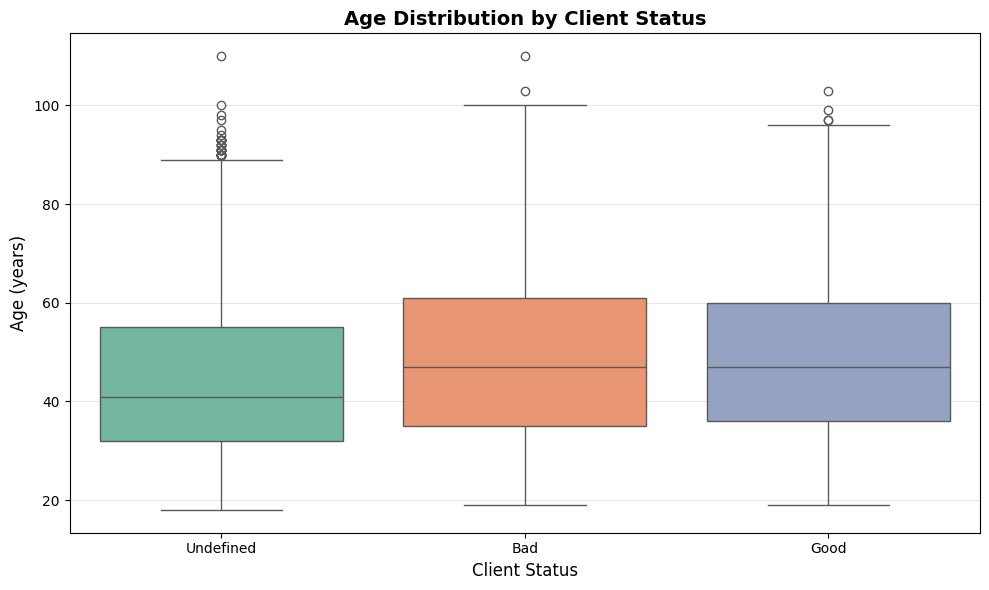


Age Statistics by Client Status:


,count,mean,std,min,25%,50%,75%,max
STATUS,,,,,,,,
Good,9637.0,48.47,15.34,19.0,36.0,47.0,60.0,103.0
Undefined,9753.0,44.54,15.60,18.0,32.0,41.0,55.0,110.0
Bad,5041.0,48.43,16.58,19.0,35.0,47.0,61.0,110.0


In [6]:
status_labels = {0: 'Good', 1: 'Undefined', 2: 'Bad'}
df_temp = df.copy()
df_temp['STATUS_LABEL'] = df_temp['STATUS'].map(status_labels)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_temp, x='STATUS_LABEL', y='WIEK', palette='Set2', hue='STATUS_LABEL', dodge=False)
plt.title('Age Distribution by Client Status', fontsize=14, fontweight='bold')
plt.xlabel('Client Status', fontsize=12)
plt.ylabel('Age (years)', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

age_stats = df.groupby('STATUS')['WIEK'].describe().round(2)
age_stats.index = age_stats.index.map(status_labels)
print("\nAge Statistics by Client Status:")
display(HTML(age_stats.to_html()))

#### Gender Distribution by Client Status

Analysis of gender distribution across client categories to identify potential gender-based credit risk patterns.

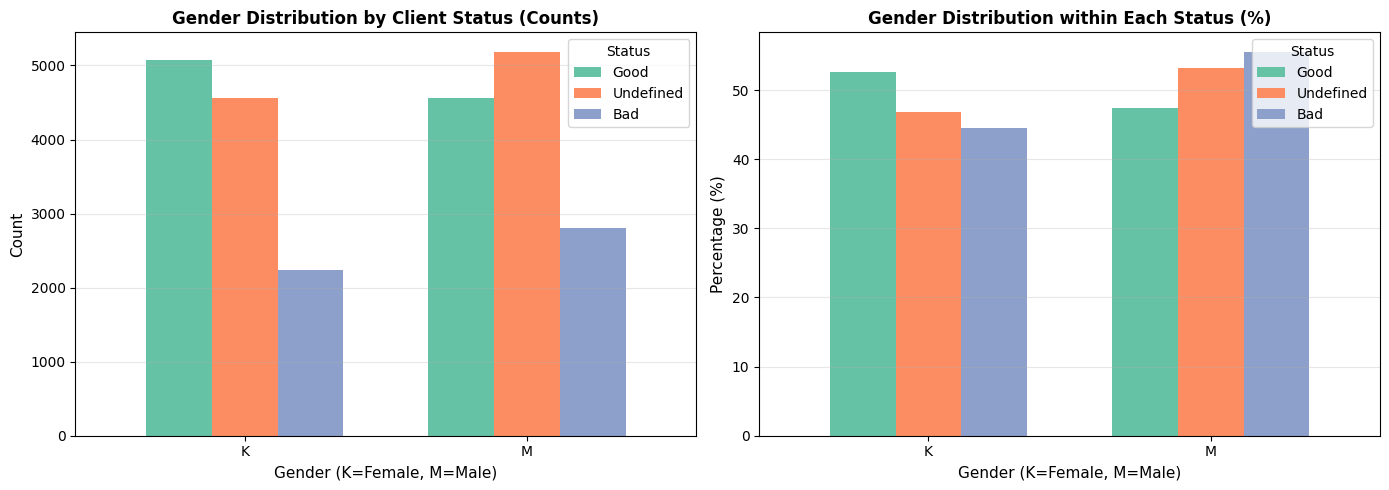


Overall Gender Distribution:
Female (K): 11,880 (48.63%)
Male (M): 12,550 (51.37%)
Total: 24,430

Gender vs Status Cross-Tabulation (Counts):


,Good,Undefined,Bad
PLEC,,,
K,5076,4564,2240
M,4561,5188,2801



Gender vs Status (Percentage within Status):


,Good,Undefined,Bad
PLEC,,,
K,52.67,46.8,44.44
M,47.33,53.2,55.56


In [26]:
df_gender = df[df['PLEC'].isin(['K', 'M'])].copy()
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
gender_status = pd.crosstab(df_gender['PLEC'], df_gender['STATUS'])
gender_status.columns = [status_labels[i] for i in gender_status.columns]
gender_status.plot(kind='bar', ax=axes[0], color=['#66c2a5', '#fc8d62', '#8da0cb'], width=0.7)
axes[0].set_title('Gender Distribution by Client Status (Counts)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Gender (K=Female, M=Male)', fontsize=11)
axes[0].set_ylabel('Count', fontsize=11)
axes[0].legend(title='Status', fontsize=10)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Percentage within status
gender_pct_status = pd.crosstab(df_gender['PLEC'], df_gender['STATUS'], normalize='columns') * 100
gender_pct_status.columns = [status_labels[i] for i in gender_pct_status.columns]
gender_pct_status.plot(kind='bar', ax=axes[1], color=['#66c2a5', '#fc8d62', '#8da0cb'], width=0.7)
axes[1].set_title('Gender Distribution within Each Status (%)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Gender (K=Female, M=Male)', fontsize=11)
axes[1].set_ylabel('Percentage (%)', fontsize=11)
axes[1].legend(title='Status', fontsize=10)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Gender counts
gender_counts = df_gender['PLEC'].value_counts()
total_gender = gender_counts.sum()
print(f"\nOverall Gender Distribution:")
print(f"Female (K): {gender_counts.get('K', 0):,} ({gender_counts.get('K', 0)/total_gender*100:.2f}%)")
print(f"Male (M): {gender_counts.get('M', 0):,} ({gender_counts.get('M', 0)/total_gender*100:.2f}%)")
print(f"Total: {total_gender:,}")

# Cross-tabulation statistics
print("\nGender vs Status Cross-Tabulation (Counts):")
display(HTML(gender_status.to_html()))
print("\nGender vs Status (Percentage within Status):")
display(HTML(gender_pct_status.round(2).to_html()))

#### Regional Distribution by Client Status

Geographic analysis using voivodeship (wojewodztwo) data to examine spatial patterns in credit risk across Polish administrative regions.

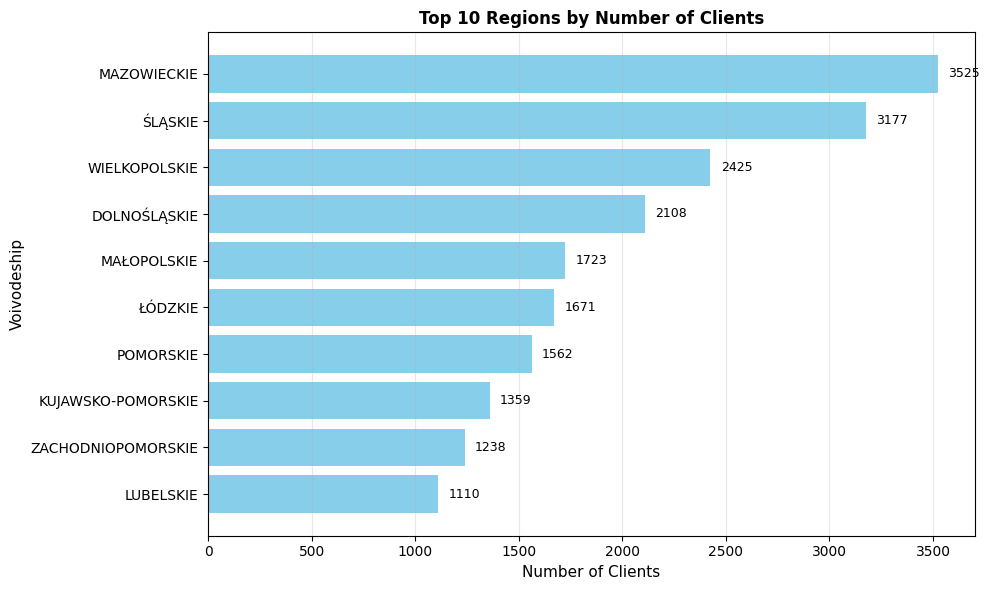

<Figure size 1200x600 with 0 Axes>

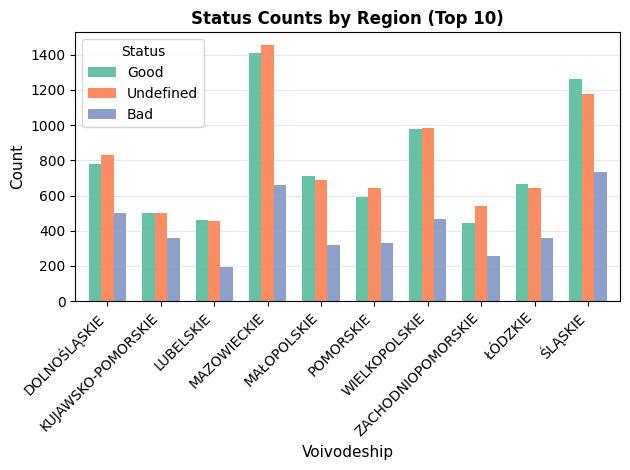

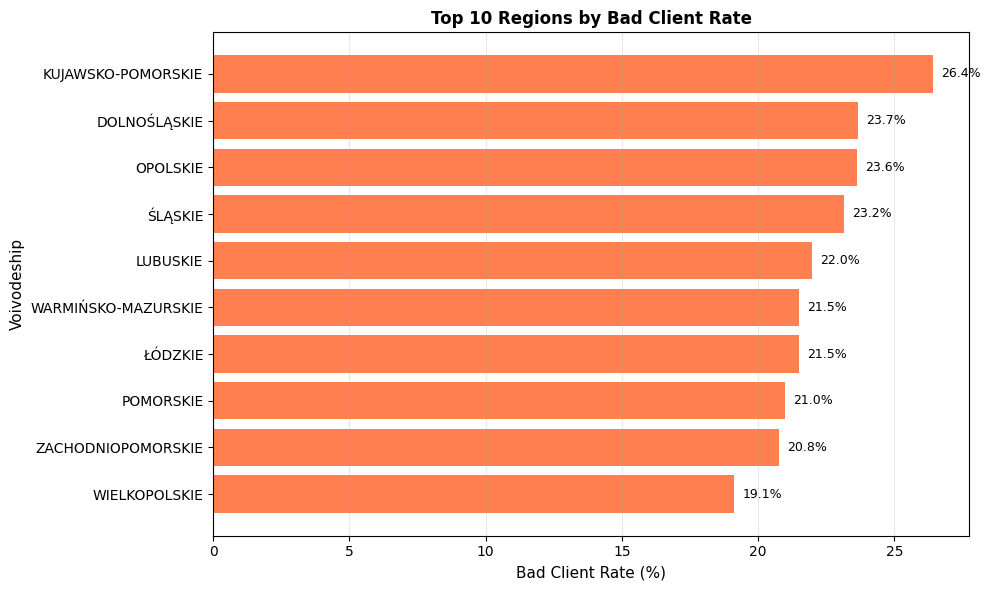

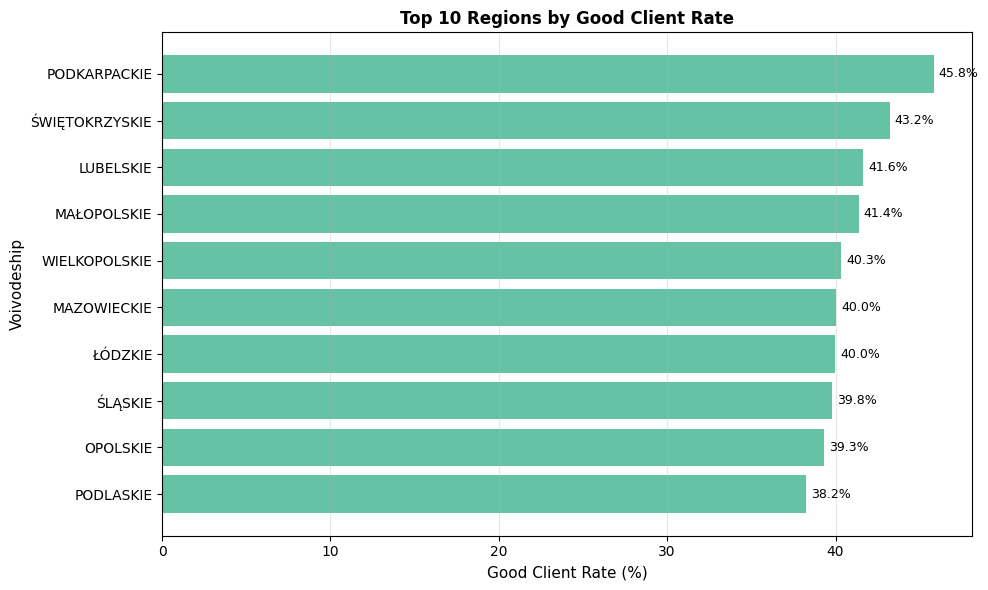

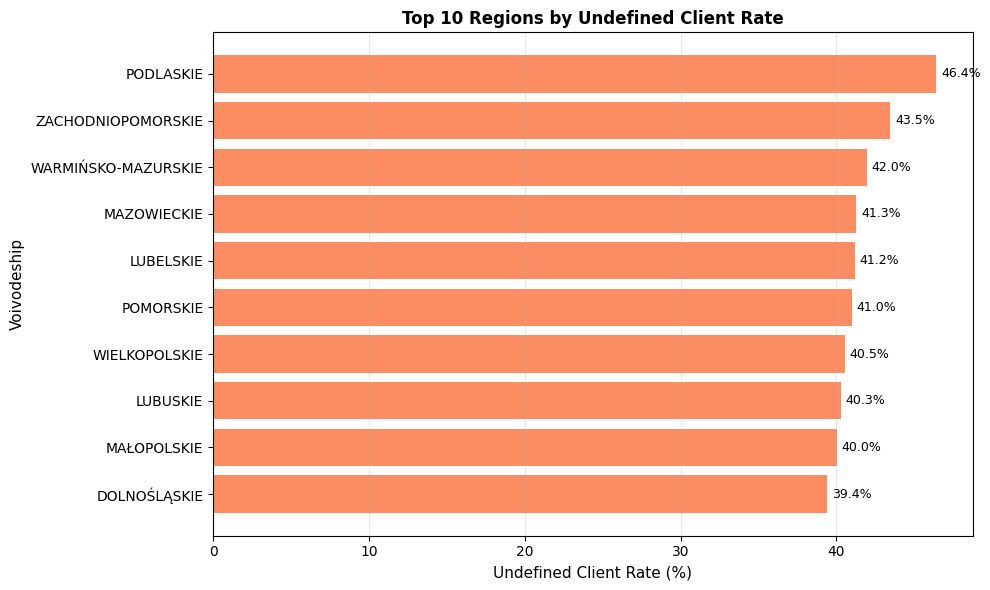


Regional Distribution Statistics (Top 10 Regions by Total Clients):


Voivodeship,Total_Clients,Good_Count,Undefined_Count,Bad_Count,Good_Rate_%,Undefined_Rate_%,Bad_Rate_%
MAZOWIECKIE,3525,778,831,499,40.03,41.28,18.70
ŚLĄSKIE,3177,500,500,359,39.82,37.02,23.17
WIELKOPOLSKIE,2425,462,457,191,40.33,40.54,19.13
DOLNOŚLĄSKIE,2108,1411,1455,659,36.91,39.42,23.67
MAŁOPOLSKIE,1723,713,690,320,41.38,40.05,18.57
ŁÓDZKIE,1671,594,640,328,39.98,38.54,21.48
POMORSKIE,1562,978,983,464,38.03,40.97,21.00
KUJAWSKO-POMORSKIE,1359,443,538,257,36.79,36.79,26.42
ZACHODNIOPOMORSKIE,1238,668,644,359,35.78,43.46,20.76
LUBELSKIE,1110,1265,1176,736,41.62,41.17,17.21


In [27]:
region_counts_all = df_temp['WOJEWODZTWO'].value_counts()
good_rate_all = df_temp.groupby('WOJEWODZTWO')['STATUS'].apply(lambda x: (x == 0).sum() / len(x) * 100)
undefined_rate_all = df_temp.groupby('WOJEWODZTWO')['STATUS'].apply(lambda x: (x == 1).sum() / len(x) * 100)
bad_rate_all = df_temp.groupby('WOJEWODZTWO')['STATUS'].apply(lambda x: (x == 2).sum() / len(x) * 100)

# 1. Distribution of clients across top 10 regions
region_counts = region_counts_all.head(10)

plt.figure(figsize=(10, 6))
plt.barh(range(len(region_counts)), region_counts.values, color='skyblue')
plt.yticks(range(len(region_counts)), region_counts.index)
plt.xlabel('Number of Clients', fontsize=11)
plt.ylabel('Voivodeship', fontsize=11)
plt.title('Top 10 Regions by Number of Clients', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(region_counts.values):
    plt.text(v + 50, i, str(v), va='center', fontsize=9)

plt.tight_layout()
plt.show()

# 2. Status counts in top 10 regions
top_regions = region_counts_all.head(10).index
df_top_regions = df_temp[df_temp['WOJEWODZTWO'].isin(top_regions)]
region_status = pd.crosstab(df_top_regions['WOJEWODZTWO'], df_top_regions['STATUS'])
region_status.columns = [status_labels[i] for i in region_status.columns]
plt.figure(figsize=(12, 6))
region_status.plot(kind='bar', color=['#66c2a5', '#fc8d62', '#8da0cb'], width=0.7)
plt.xlabel('Voivodeship', fontsize=11)
plt.ylabel('Count', fontsize=11)
plt.title('Status Counts by Region (Top 10)', fontsize=12, fontweight='bold')
plt.legend(title='Status', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Bad client rate by region (Top 10 - highest bad rate first)
bad_rate_sorted = bad_rate_all.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(range(len(bad_rate_sorted)), bad_rate_sorted.values, color='coral')
plt.yticks(range(len(bad_rate_sorted)), bad_rate_sorted.index)
plt.xlabel('Bad Client Rate (%)', fontsize=11)
plt.ylabel('Voivodeship', fontsize=11)
plt.title('Top 10 Regions by Bad Client Rate', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

for i, v in enumerate(bad_rate_sorted.values):
    plt.text(v + 0.3, i, f'{v:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# 5. Good client rate by region (Top 10 - highest good rate first)
good_rate_sorted = good_rate_all.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(range(len(good_rate_sorted)), good_rate_sorted.values, color='#66c2a5')
plt.yticks(range(len(good_rate_sorted)), good_rate_sorted.index)
plt.xlabel('Good Client Rate (%)', fontsize=11)
plt.ylabel('Voivodeship', fontsize=11)
plt.title('Top 10 Regions by Good Client Rate', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

for i, v in enumerate(good_rate_sorted.values):
    plt.text(v + 0.3, i, f'{v:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# 6. Undefined client rate by region (Top 10 - highest undefined rate first)
undefined_rate_sorted = undefined_rate_all.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(range(len(undefined_rate_sorted)), undefined_rate_sorted.values, color='#fc8d62')
plt.yticks(range(len(undefined_rate_sorted)), undefined_rate_sorted.index)
plt.xlabel('Undefined Client Rate (%)', fontsize=11)
plt.ylabel('Voivodeship', fontsize=11)
plt.title('Top 10 Regions by Undefined Client Rate', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

for i, v in enumerate(undefined_rate_sorted.values):
    plt.text(v + 0.3, i, f'{v:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Display statistics table for top 10 regions by total clients
print("\nRegional Distribution Statistics (Top 10 Regions by Total Clients):")
top_regions_for_table = region_counts_all.head(10).index
region_status_table = pd.crosstab(df_temp[df_temp['WOJEWODZTWO'].isin(top_regions_for_table)]['WOJEWODZTWO'], 
                                   df_temp[df_temp['WOJEWODZTWO'].isin(top_regions_for_table)]['STATUS'])
region_status_table.columns = [status_labels[i] for i in region_status_table.columns]

regional_stats = pd.DataFrame({
    'Voivodeship': top_regions_for_table,
    'Total_Clients': region_counts_all.loc[top_regions_for_table].values,
    'Good_Count': region_status_table['Good'].values,
    'Undefined_Count': region_status_table['Undefined'].values,
    'Bad_Count': region_status_table['Bad'].values,
    'Good_Rate_%': good_rate_all.loc[top_regions_for_table].round(2).values,
    'Undefined_Rate_%': undefined_rate_all.loc[top_regions_for_table].round(2).values,
    'Bad_Rate_%': bad_rate_all.loc[top_regions_for_table].round(2).values
})
display(HTML(regional_stats.to_html(index=False)))

#### Demographic Correlations with Client Status

Correlation analysis between demographic features and client status to quantify the strength of relationships.

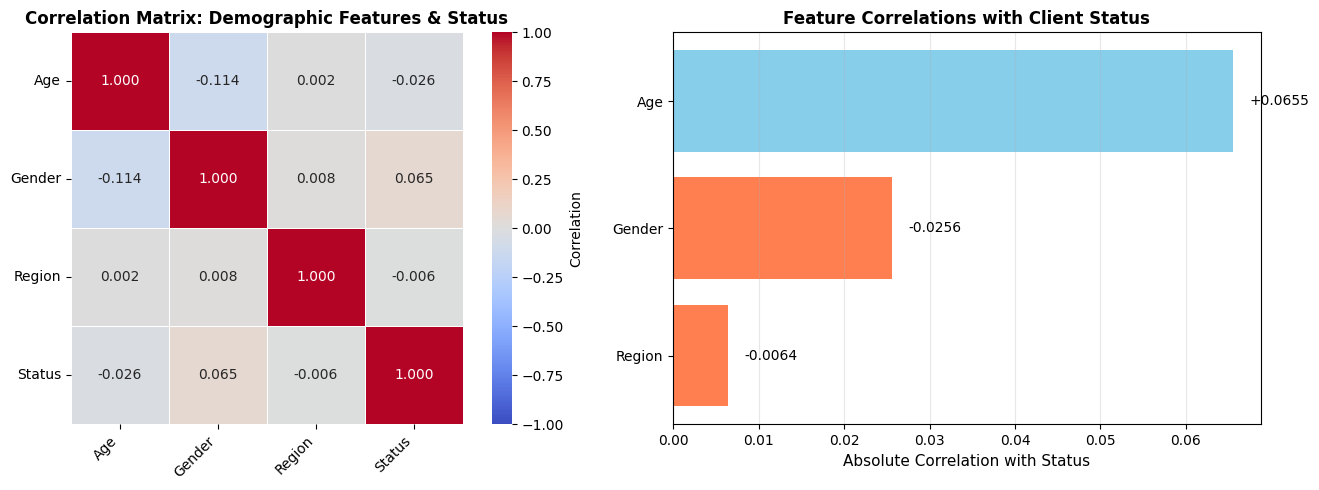


Correlations with Client Status:


Feature,Correlation,Abs_Correlation
Age (WIEK),-0.0256,0.0256
Gender (PLEC),0.0655,0.0655
Region (WOJEWODZTWO),-0.0064,0.0064


In [28]:
df_demo = df.copy()
df_demo['PLEC_ENCODED'] = df_demo['PLEC'].map({'K': 0, 'M': 1})
le_region = LabelEncoder()
df_demo['WOJEWODZTWO_ENCODED'] = le_region.fit_transform(df_demo['WOJEWODZTWO'].astype(str))
demo_features = ['WIEK', 'PLEC_ENCODED', 'WOJEWODZTWO_ENCODED', 'STATUS']
demo_corr = df_demo[demo_features].corr()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap of correlations
sns.heatmap(demo_corr, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, ax=axes[0], cbar_kws={'label': 'Correlation'}, 
            vmin=-1, vmax=1, linewidths=0.5)
axes[0].set_title('Correlation Matrix: Demographic Features & Status', fontsize=12, fontweight='bold')
axes[0].set_xticklabels(['Age', 'Gender', 'Region', 'Status'], rotation=45, ha='right')
axes[0].set_yticklabels(['Age', 'Gender', 'Region', 'Status'], rotation=0)

# Bar plot of correlations with STATUS
status_corr = demo_corr['STATUS'].drop('STATUS').abs().sort_values(ascending=False)
colors = ['coral' if demo_corr.loc[feat, 'STATUS'] < 0 else 'skyblue' for feat in status_corr.index]
axes[1].barh(range(len(status_corr)), status_corr.values, color=colors)
axes[1].set_yticks(range(len(status_corr)))
axes[1].set_yticklabels(['Age', 'Gender', 'Region'])
axes[1].set_xlabel('Absolute Correlation with Status', fontsize=11)
axes[1].set_title('Feature Correlations with Client Status', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)


for i, (feat, val) in enumerate(zip(status_corr.index, status_corr.values)):
    sign = '+' if demo_corr.loc[feat, 'STATUS'] > 0 else '-'
    axes[1].text(val + 0.002, i, f'{sign}{val:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\nCorrelations with Client Status:")
status_corr_df = pd.DataFrame({
    'Feature': ['Age (WIEK)', 'Gender (PLEC)', 'Region (WOJEWODZTWO)'],
    'Correlation': [demo_corr.loc['WIEK', 'STATUS'], 
                    demo_corr.loc['PLEC_ENCODED', 'STATUS'],
                    demo_corr.loc['WOJEWODZTWO_ENCODED', 'STATUS']],
    'Abs_Correlation': [abs(demo_corr.loc['WIEK', 'STATUS']), 
                        abs(demo_corr.loc['PLEC_ENCODED', 'STATUS']),
                        abs(demo_corr.loc['WOJEWODZTWO_ENCODED', 'STATUS'])]
})
display(HTML(status_corr_df.round(4).to_html(index=False)))

#### Combined Demographic Analysis

Multi-dimensional analysis examining interactions between age, gender, and client status.

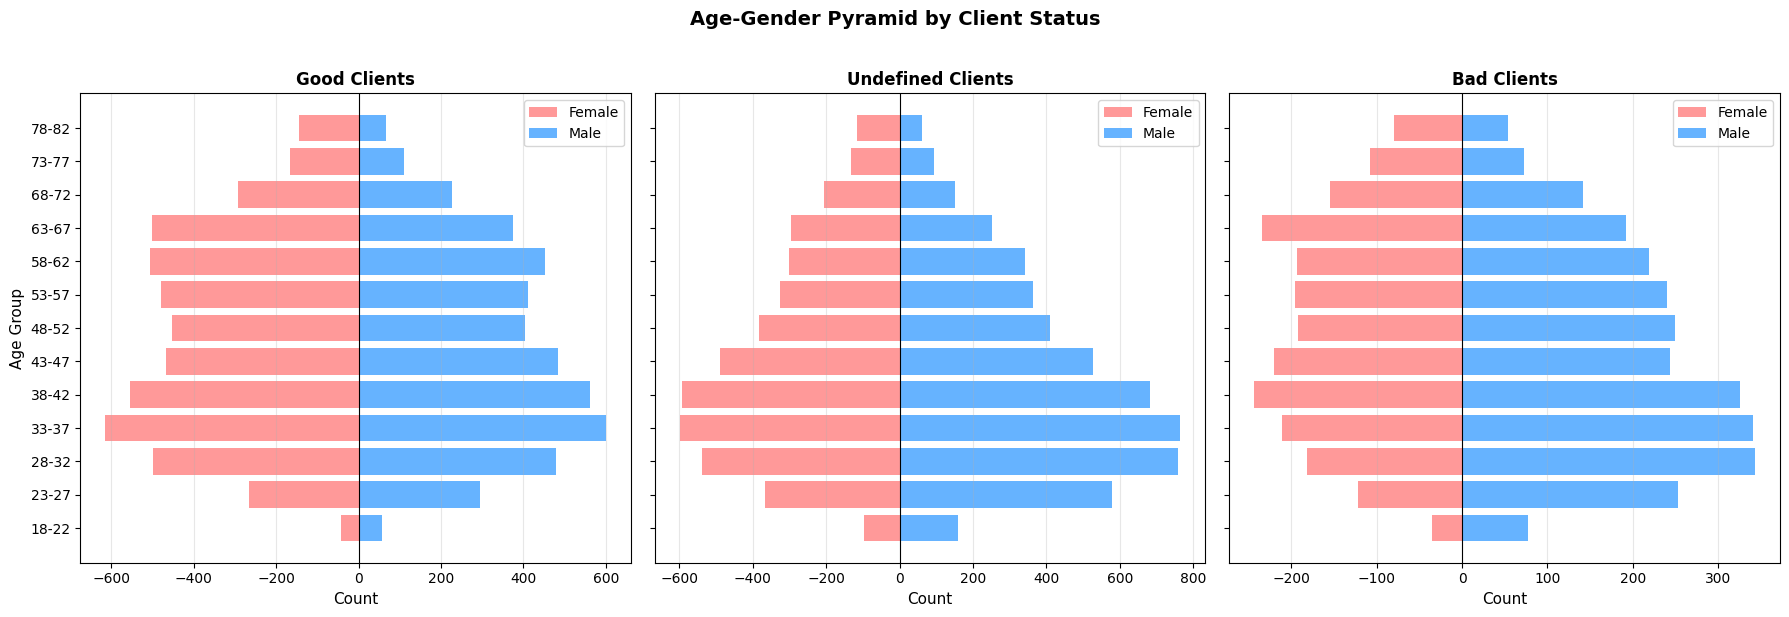

<Figure size 1200x500 with 0 Axes>

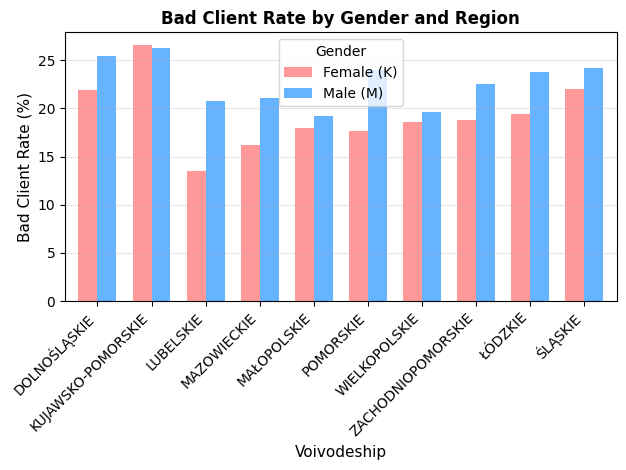

In [29]:
# Remove gender X from both dataframes
df = df[df['PLEC'].isin(['K', 'M'])].copy()
df_temp = df_temp[df_temp['PLEC'].isin(['K', 'M'])].copy()


# Age-Gender Pyramid by Client Status
df_temp['AGE_GROUP'] = pd.cut(df_temp['WIEK'], bins=[0, 30, 40, 50, 60, 100], 
                               labels=['<30', '30-40', '40-50', '50-60', '60+'])

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

age_bins = range(18, 85, 5)
age_labels = [f'{i}-{i+4}' for i in age_bins[:-1]]

for idx, (status_val, status_label) in enumerate(status_labels.items()):
    df_status = df_temp[df_temp['STATUS'] == status_val].copy()
    df_status['AGE_BIN'] = pd.cut(df_status['WIEK'], bins=age_bins, labels=age_labels, right=False)

    # Female counts (negative)
    female_counts = df_status[df_status['PLEC'] == 'K'].groupby('AGE_BIN', observed=True).size()
    female_counts = -female_counts.reindex(age_labels, fill_value=0)

    # Male counts (positive)
    male_counts = df_status[df_status['PLEC'] == 'M'].groupby('AGE_BIN', observed=True).size()
    male_counts = male_counts.reindex(age_labels, fill_value=0)

    y_pos = range(len(age_labels))
    axes[idx].barh(y_pos, female_counts, color='#ff9999', label='Female')
    axes[idx].barh(y_pos, male_counts, color='#66b3ff', label='Male')
    axes[idx].set_yticks(y_pos)
    axes[idx].set_yticklabels(age_labels)
    axes[idx].set_xlabel('Count', fontsize=11)
    axes[idx].set_title(f'{status_label} Clients', fontsize=12, fontweight='bold')
    axes[idx].axvline(0, color='black', linewidth=0.8)
    axes[idx].grid(axis='x', alpha=0.3)
    axes[idx].legend()

axes[0].set_ylabel('Age Group', fontsize=11)
plt.suptitle('Age-Gender Pyramid by Client Status', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Gender-Region Risk Matrix
top_10_regions_list = df_temp['WOJEWODZTWO'].value_counts().head(10).index.tolist()

gender_region_bad_rate = df_temp[df_temp['WOJEWODZTWO'].isin(top_10_regions_list)].groupby(['WOJEWODZTWO', 'PLEC'])['STATUS'].apply(
    lambda x: (x == 2).sum() / len(x) * 100 if len(x) > 0 else 0
).unstack(fill_value=0)

plt.figure(figsize=(12, 5))
gender_region_bad_rate.plot(kind='bar', color=['#ff9999', '#66b3ff'], width=0.7)
plt.xlabel('Voivodeship', fontsize=11)
plt.ylabel('Bad Client Rate (%)', fontsize=11)
plt.title('Bad Client Rate by Gender and Region', fontsize=12, fontweight='bold')
plt.legend(title='Gender', labels=['Female (K)', 'Male (M)'], fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


### Data Cleaning

To successfully perform Univariate Analysis, Bivariate Analysis and effectively express the meaning of the data a procedure of cleaning is necessary.

To start, categorization to numerical and categorical variables is necessary. To perform the classification a documentation received from BIK is used.

Several columns were read as "object", but according to the documentation and observation of values, they should fall into numerical category - classification is done "by hand".

Many columns, such as "ILE_BANKOW_12", are both numerical and categorical: according to the documentation, this column represents a number of queries sent from other banks to BIK asking about a specific client within last 12 months. A value can be equal or greater than 0, but it also may hold "-99000792" value, indicating there were no queries sent in that period. To display the mean, median, standard deviation etc. the "-99000792" needs to be filtred.

To achieve that the solution is to replace "the magic value" of -99000792 with 0 - the meaning remains the same.

In [16]:
df = df.replace(-99000792, 0)

Grouping the column into categories based on their description provided in the documentation and early observation (ID column is omitted).

In [17]:
numerical_cols = list(df.columns[1:40]) + ["TERYT"] + ["WIEK"]
categorical_cols = list(df.columns[42:45]) + ["PLEC"]

num_str = ", ".join(numerical_cols)
cat_str = ", ".join(categorical_cols)

print(f"Numerical columns ({len(numerical_cols)}):")
print(textwrap.fill(num_str, width=200))
print()
print(f"Categorical columns ({len(categorical_cols)}):")
print(textwrap.fill(cat_str, width=200))

Numerical columns (41):
ILE_BANKOW, ILE_BANKOW_12, ILE_MIES_OD_NAJSTAR_OTW, ILE_MIES_OD_NAJSTAR_OTW_NRAT, ILE_MIES_OD_NAJSTAR_OTW_RAT, ILE_PRODUKTOW, ILE_RACH_OTW, ILE_RACH_OTW_12, ILE_RACH_OTW_NRAT, ILE_RACH_OTW_NRAT_12,
ILE_RACH_OTW_RAT, ILE_RACH_OTW_RAT_12, ILE_RACH_OTW_BEZ_HIPO, ILE_RACH_OTW_KARTY, ILE_RACH_OTW_ODNAWIALNE, ILE_RACH_ZAMK, ILE_ZAPYTAN_12, ILE_ZAPYTAN_3, ILE_ZAPYTAN_6, ILE_ZAPYTAN_9, L_RACHUNKOW,
MAX_NAL_WYMAGAL, MAX_RATA, MAX_WNIOSKODAWCY, MIN_L_RAT_DO_SPLATY, SUMA_DO_SPLATY, SUMA_DO_SPLATY_BEZ_HIPO, SUMA_DO_SPLATY_KARTY, SUMA_DO_SPLATY_NRAT, SUMA_DO_SPLATY_ODNAWIALNE, SUMA_DO_SPLATY_RAT,
SUMA_LIMIT, SUMA_LIMIT_KARTY, SUMA_LIMIT_ODNAWIALNE, SUMA_NAL_WYMAGAL, SUMA_NAL_WYMAGAL_BEZ_HIPO, SUMA_NAL_WYMAGAL_KARTY, SUMA_NAL_WYMAGAL_NRAT, SUMA_RATA, TERYT, WIEK

Categorical columns (4):
WOJEWODZTWO, POWIAT, GMINA, PLEC


Data type unification for numeric type (several column where stored as an 'object'):

In [18]:
for col in numerical_cols:
    t = df[col].astype(str).str.strip().str.replace(',', '.', regex=False).str.replace(r'\s+', '', regex=True)
    parsed = pd.to_numeric(t, errors='coerce')
    df[col] = parsed.astype('float64')

In [19]:
df_info = pd.DataFrame({
    "column": df.columns,
    "dtype": df.dtypes.values,
    "non_null": df.notnull().sum().values,
    "null": df.isnull().sum().values,
    "unique": df.nunique(dropna=True).values,
    "memory_bytes": df.memory_usage(deep=True, index=False).values, # deep - includes full python-level memory introspection, index=False - as the result returned Series has one element
    "example": [df[col].dropna().iloc[0] if df[col].notna().any() else None for col in df.columns] # first non-null value from the dropna() result or None if all are null
})

df_info.index = range(1, len(df_info) + 1) # start index from 1 
html = df_info.to_html(classes="df-info", border=0) # no border
scrollable = f'<div style="max-height:420px; overflow:auto; border:1px solid #ddd; padding:6px;">{html}</div>' # scrollable div
display(HTML(scrollable))

display(HTML(df.describe(include='all').to_html(float_format='{:,.0f}'.format)))

,column,dtype,non_null,null,unique,memory_bytes,example
1,ID,int64,24431,0,24431,195448,10474
2,ILE_BANKOW,float64,24431,0,10,195448,1.0
3,ILE_BANKOW_12,float64,24431,0,16,195448,1.0
4,ILE_MIES_OD_NAJSTAR_OTW,float64,24431,0,5631,195448,3.23
5,ILE_MIES_OD_NAJSTAR_OTW_NRAT,float64,24431,0,5381,195448,3.23
6,ILE_MIES_OD_NAJSTAR_OTW_RAT,float64,24431,0,3698,195448,0.0
7,ILE_PRODUKTOW,float64,24431,0,7,195448,1.0
8,ILE_RACH_OTW,float64,24431,0,25,195448,1.0
9,ILE_RACH_OTW_12,float64,24431,0,20,195448,1.0
10,ILE_RACH_OTW_NRAT,float64,24431,0,11,195448,1.0


,ID,ILE_BANKOW,ILE_BANKOW_12,ILE_MIES_OD_NAJSTAR_OTW,ILE_MIES_OD_NAJSTAR_OTW_NRAT,ILE_MIES_OD_NAJSTAR_OTW_RAT,ILE_PRODUKTOW,ILE_RACH_OTW,ILE_RACH_OTW_12,ILE_RACH_OTW_NRAT,ILE_RACH_OTW_NRAT_12,ILE_RACH_OTW_RAT,ILE_RACH_OTW_RAT_12,ILE_RACH_OTW_BEZ_HIPO,ILE_RACH_OTW_KARTY,ILE_RACH_OTW_ODNAWIALNE,ILE_RACH_ZAMK,ILE_ZAPYTAN_12,ILE_ZAPYTAN_3,ILE_ZAPYTAN_6,ILE_ZAPYTAN_9,L_RACHUNKOW,MAX_NAL_WYMAGAL,MAX_RATA,MAX_WNIOSKODAWCY,MIN_L_RAT_DO_SPLATY,SUMA_DO_SPLATY,SUMA_DO_SPLATY_BEZ_HIPO,SUMA_DO_SPLATY_KARTY,SUMA_DO_SPLATY_NRAT,SUMA_DO_SPLATY_ODNAWIALNE,SUMA_DO_SPLATY_RAT,SUMA_LIMIT,SUMA_LIMIT_KARTY,SUMA_LIMIT_ODNAWIALNE,SUMA_NAL_WYMAGAL,SUMA_NAL_WYMAGAL_BEZ_HIPO,SUMA_NAL_WYMAGAL_KARTY,SUMA_NAL_WYMAGAL_NRAT,SUMA_RATA,STATUS,TERYT,WOJEWODZTWO,POWIAT,GMINA,WIEK,PLEC
count,"24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431",24431,24431,24431,"24,431",24431
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,370,2123,NaN,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MAZOWIECKIE,WARSZAWA,WARSZAWA,NaN,M
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3525,1289,1289,NaN,12550
mean,"12,265",2,1,87,67,38,2,2,1,1,0,1,1,2,1,0,3,1,0,1,1,5,"4,747","1,618",1,137,"63,721","18,172",863,"2,014","1,105","61,682","4,648","2,551","2,022","5,545","3,150",174,374,"1,896",1,"173,015",NaN,NaN,NaN,47,NaN
std,"7,078",1,1,76,83,43,1,2,1,1,0,1,1,2,1,1,5,3,1,2,2,6,"61,899","25,347",1,705,"194,579","64,381","3,718","8,445","5,732","193,063","12,869","7,654","7,170","64,485","22,424","1,935","3,836","27,869",1,"93,125",NaN,NaN,NaN,16,NaN
min,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"20,101",NaN,NaN,NaN,18,NaN
25%,"6,132",1,0,26,0,2,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,2,0,0,1,0,600,15,0,0,0,0,0,0,0,0,0,0,0,0,0,"101,709",NaN,NaN,NaN,34,NaN
50%,"12,269",1,0,77,35,21,2,2,0,1,0,1,0,2,0,0,2,0,0,0,0,4,0,274,1,7,"8,278","3,555",0,0,0,"6,502","1,000",0,0,0,0,0,0,339,1,"146,501",NaN,NaN,NaN,44,NaN
75%,"18,394",2,1,123,110,64,3,3,1,1,0,2,1,3,1,1,4,2,0,1,1,7,273,707,2,30,"46,498","17,661",20,"1,114",0,"43,254","4,500","2,000","1,000",307,206,0,0,954,1,"246,901",NaN,NaN,NaN,59,NaN


### Dataset Overview: Cleaning Results

Numerical columns:

In [10]:
descr_html = df[numerical_cols].describe(include='all').to_html(
    float_format='{:,.0f}'.format,
    classes='df-describe'
)

style = """
<style>
.container { max-height:600px; overflow:auto; border:1px solid #ddd; padding:6px; }
.df-describe { border-collapse: collapse; min-width: 900px; }
.df-describe th, .df-describe td { padding:6px; border:1px solid #eee; white-space: nowrap; }
.df-describe thead th { position: sticky; top: 0; background: inherit; z-index: 3; }
.df-describe thead th:first-child { left: 0; z-index: 4; }
.df-describe tbody th { position: sticky; left: 0; background: inherit; z-index: 2; }
</style>
"""

display(HTML(f"{style}<div class='container'>{descr_html}</div>"))

,ILE_BANKOW,ILE_BANKOW_12,ILE_MIES_OD_NAJSTAR_OTW,ILE_MIES_OD_NAJSTAR_OTW_NRAT,ILE_MIES_OD_NAJSTAR_OTW_RAT,ILE_PRODUKTOW,ILE_RACH_OTW,ILE_RACH_OTW_12,ILE_RACH_OTW_NRAT,ILE_RACH_OTW_NRAT_12,ILE_RACH_OTW_RAT,ILE_RACH_OTW_RAT_12,ILE_RACH_OTW_BEZ_HIPO,ILE_RACH_OTW_KARTY,ILE_RACH_OTW_ODNAWIALNE,ILE_RACH_ZAMK,ILE_ZAPYTAN_12,ILE_ZAPYTAN_3,ILE_ZAPYTAN_6,ILE_ZAPYTAN_9,L_RACHUNKOW,MAX_NAL_WYMAGAL,MAX_RATA,MAX_WNIOSKODAWCY,MIN_L_RAT_DO_SPLATY,SUMA_DO_SPLATY,SUMA_DO_SPLATY_BEZ_HIPO,SUMA_DO_SPLATY_KARTY,SUMA_DO_SPLATY_NRAT,SUMA_DO_SPLATY_ODNAWIALNE,SUMA_DO_SPLATY_RAT,SUMA_LIMIT,SUMA_LIMIT_KARTY,SUMA_LIMIT_ODNAWIALNE,SUMA_NAL_WYMAGAL,SUMA_NAL_WYMAGAL_BEZ_HIPO,SUMA_NAL_WYMAGAL_KARTY,SUMA_NAL_WYMAGAL_NRAT,SUMA_RATA,TERYT,WIEK
count,"24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431","24,431"
mean,2,1,"-2,192,186","-34,371,212","-23,332,881",2,2,1,1,0,1,1,2,1,0,3,1,0,1,1,5,"4,747","1,618",1,137,"-9,888,633","-15,465,518",863,"2,014","1,105","-27,112,781","4,648","2,551","2,022","-9,946,809","-15,480,540",174,374,"1,896","173,015",47
std,1,1,"14,568,452","47,132,734","42,019,358",1,2,1,1,0,1,1,2,1,1,5,3,1,2,2,6,"61,899","25,347",1,705,"29,792,349","35,969,052","3,718","8,445","5,732","44,218,906","12,869","7,654","7,170","29,772,342","35,962,534","1,935","3,836","27,869","93,125",16
min,0,0,"-99,000,792","-99,000,792","-99,000,792",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,-1,-1,0,"-99,000,792","-99,000,792",0,0,0,"-99,000,792",0,0,0,"-99,000,792","-99,000,792",0,0,0,"20,101",18
25%,1,0,26,"-99,000,792",2,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,2,0,0,1,0,600,15,0,0,0,"-99,000,792",0,0,0,0,0,0,0,0,"101,709",34
50%,1,0,77,35,21,2,2,0,1,0,1,0,2,0,0,2,0,0,0,0,4,0,274,1,7,"8,278","3,555",0,0,0,"6,502","1,000",0,0,0,0,0,0,339,"146,501",44
75%,2,1,123,110,64,3,3,1,1,0,2,1,3,1,1,4,2,0,1,1,7,273,707,2,30,"46,498","17,661",20,"1,114",0,"43,254","4,500","2,000","1,000",307,206,0,0,954,"246,901",59
max,9,15,483,483,263,6,34,27,10,4,34,26,34,7,5,134,35,17,31,35,142,"4,358,023","1,908,450",7,"48,811","14,065,695","5,853,267","230,148","359,000","247,082","14,063,992","576,796","278,000","352,000","4,358,023","1,499,291","167,108","247,082","2,009,096","326,301",110


### Univariate Analysis

To understand the characteristics and distribution of each variable Univariate Analysis is performed.

With the use of descriptive statistics together visualization using plots and graphs this section provides detailed information of every column in the dataset.

#### Visualization

Multi-plot grid of boxplots for numerical columns:

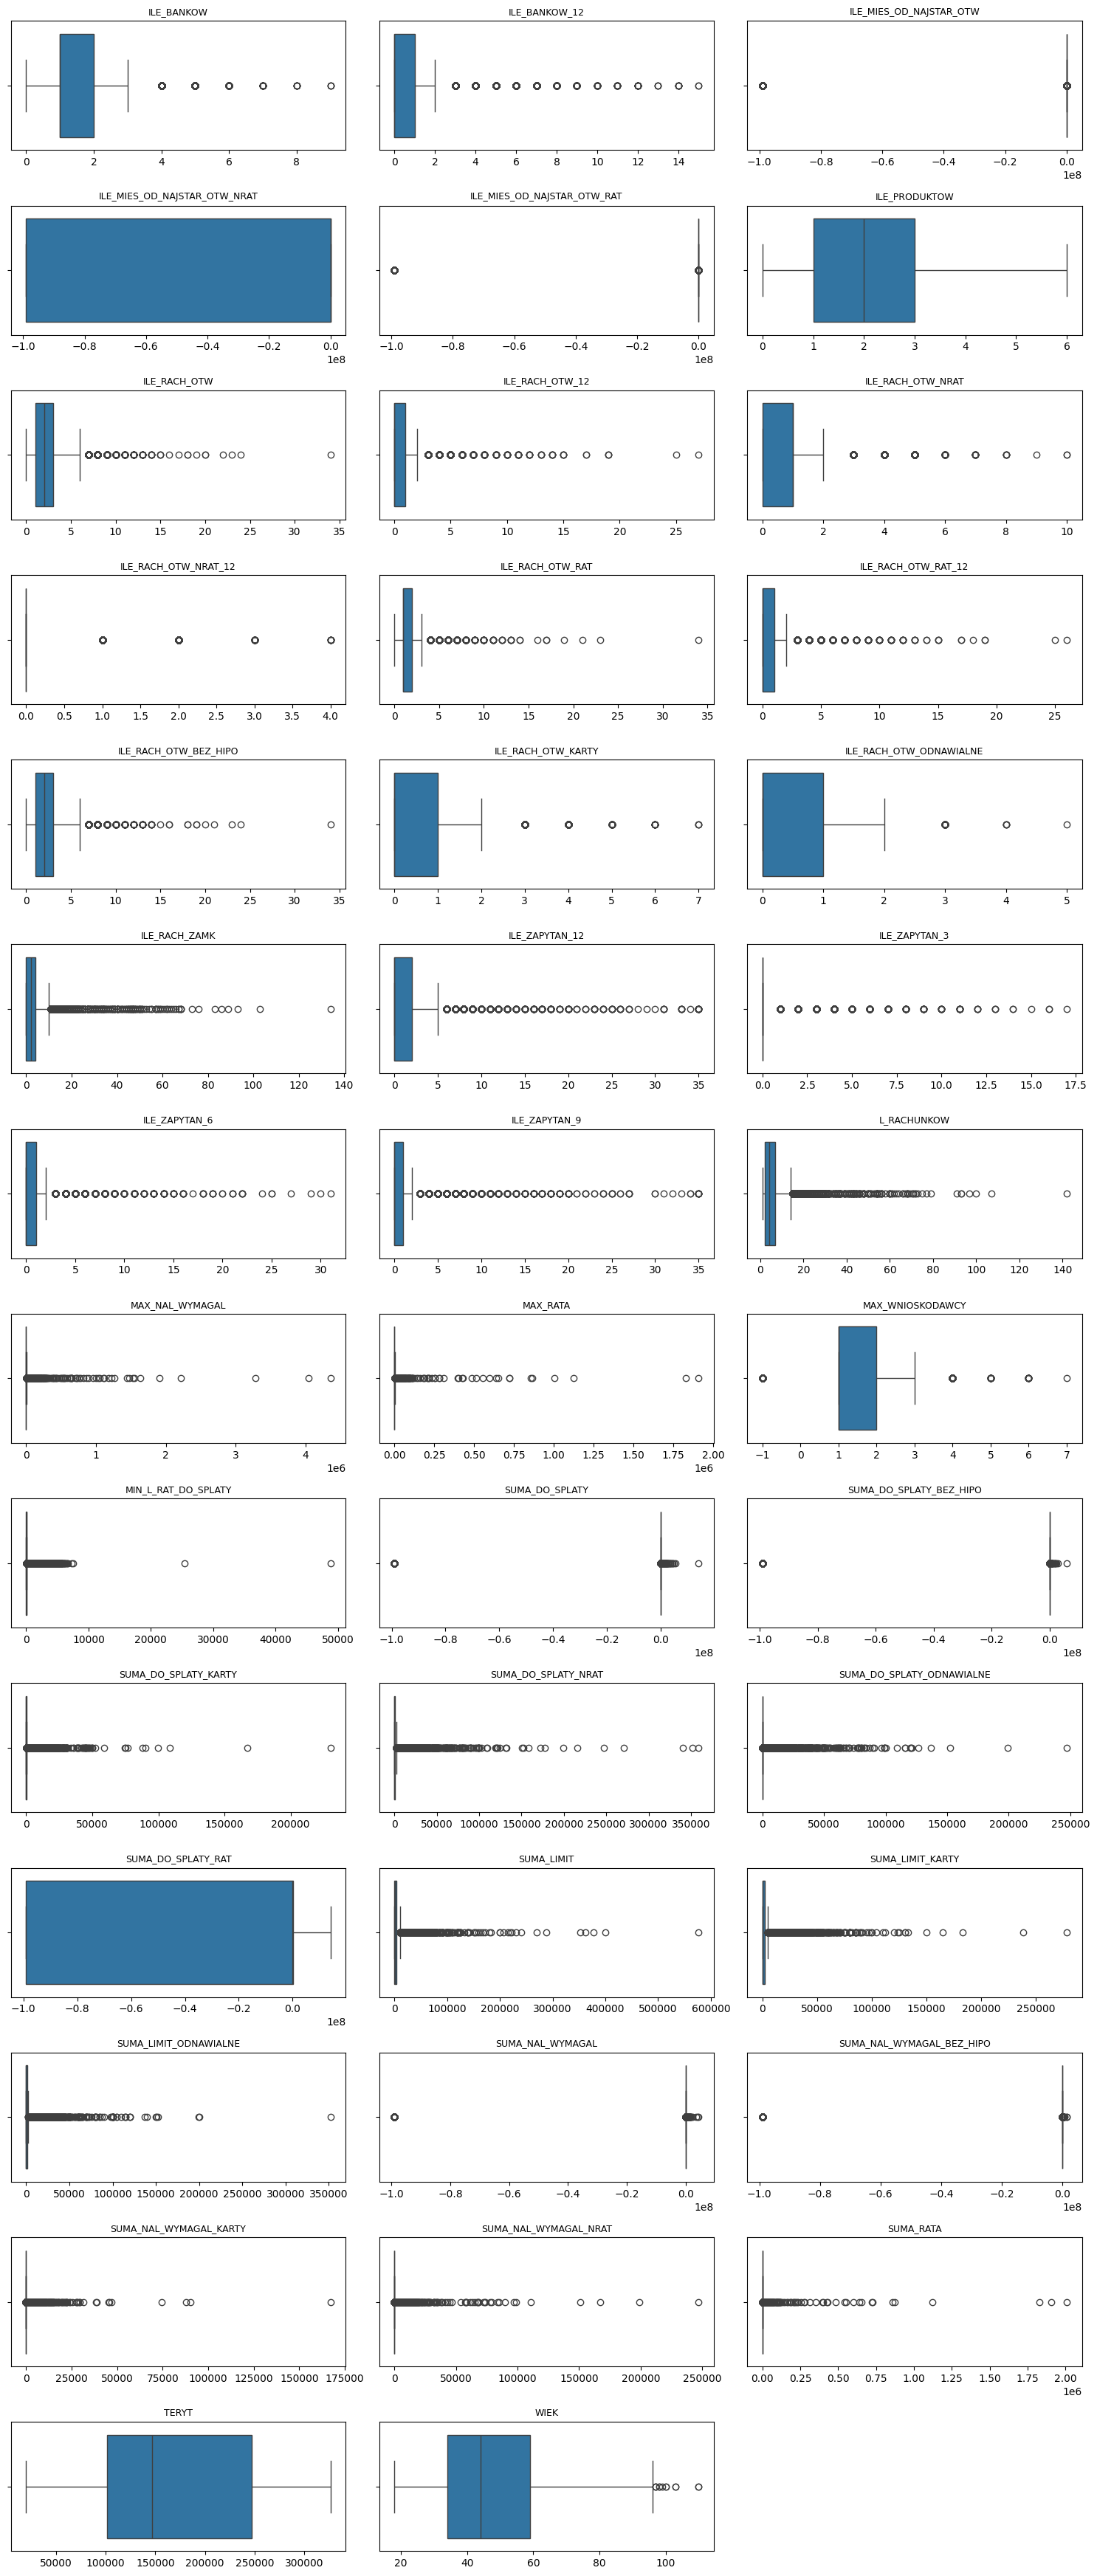

In [11]:
n = len(numerical_cols)
if n == 0:
    print("No numerical columns found.")
else:
    per_row = 3
    nrows = math.ceil(n / per_row)
    figsize = (per_row * 5, max(3, nrows * 2.5))
    fig, axes = plt.subplots(nrows, per_row, figsize=figsize)
    axes = np.array(axes).flatten()

    for i, col in enumerate(numerical_cols):
        ax = axes[i]
        data = df[col].dropna()
        if data.empty:
            ax.text(0.5, 0.5, "no data", ha="center", va="center")
            ax.set_title(col, fontsize=9)
            ax.set_axis_off()
            continue

        sns.boxplot(x=data, ax=ax, color="C0")
        ax.set_title(col, fontsize=9)
        ax.set_xlabel("")

    for j in range(n, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

Understanding of the correlation between the variables is a crucial task - highly correlated features might confuse the model - it may happend that several column are describing a similar phenomena.

Correlation plot of the numerical variables:

In [12]:
corr = df[numerical_cols].corr()

# mask upper triangle so plot shows each pair once
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
corr_masked = corr.mask(mask)

fig = px.imshow(
    corr_masked,
    x=corr_masked.columns,
    y=corr_masked.index,
    color_continuous_scale="RdBu",
    zmin=-1,
    zmax=1,
    labels={"x":"Feature", "y":"Feature", "color":"Correlation"},
    text_auto=".2f",
    aspect="auto",
)
fig.update_layout(title="Interactive correlation matrix - numerical columns", width=1800, height=900)
fig.show()

Complex analysis provided by ydata_profiling saved as a .HTML file:

In [20]:
profile = ProfileReport(df, title="Credit Scoring Dataset Report", explorative=True)
profile.to_file("credit_scoring_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 47/47 [00:01<00:00, 35.47it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Data Preparation

In the previous section data was prepared (cleaned) for the analysis purpose. The exploration allowed to detect some potential problems with a dataset, that may result in model's inaccuracy, those are outliers and very high correlations. A goal of this chapter is to make real data manipulation in response to the problematic issues.

### Preprocessing

Based on the correlation plot from a pair of variable with corr > ~0.95 one of the variable should be removed. The selection is case-sensitive and it is done by hand based on the analysis results above. Hoever, most of the times a variable with "more" standard distribution, less zeros and fewer missing values is better - but the documentation with variables definition cannot be forgotten.

In [22]:
corr_col_to_drop = ['ILE_MIES_OD_NAJSTAR_OTW_NRAT', 'ILE_RACH_OTW_BEZ_HIPO', 'ILE_RACH_OTW_RAT_12', 'ILE_RACH_ZAMK',
                    'ILE_ZAPYTAN_9', 'SUMA_NAL_WYMAGAL', 'SUMA_RATA', 'SUMA_DO_SPLATY_RAT', "SUMA_NAL_WYMAGAL_BEZ_HIPO"] # manually selected columns with suspiciously high correlation
df_no_high_corr = df.copy()
df_no_high_corr.drop(columns=corr_col_to_drop, inplace=True)

Assuring the right correlations after preprocessing:

In [23]:
num_cols_present = [c for c in numerical_cols if c in df_no_high_corr.columns]
corr = df_no_high_corr[num_cols_present].corr()

# mask upper triangle so plot shows each pair once
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
corr_masked = corr.mask(mask)

fig = px.imshow(
    corr_masked,
    x=corr_masked.columns,
    y=corr_masked.index,
    color_continuous_scale="RdBu",
    zmin=-1,
    zmax=1,
    labels={"x":"Feature", "y":"Feature", "color":"Correlation"},
    text_auto=".2f",
    aspect="auto",
)
fig.update_layout(title="Interactive correlation matrix - numerical columns", width=1800, height=900)
fig.show()

### Outlier Handling

Analized columns: 32
Total winsorized values: 6298
Top 10 (column -> number of caps):
  WIEK: 342
  TERYT: 274
  MAX_NAL_WYMAGAL: 245
  MAX_RATA: 245
  SUMA_DO_SPLATY: 245
  SUMA_DO_SPLATY_BEZ_HIPO: 245
  SUMA_DO_SPLATY_KARTY: 245
  SUMA_DO_SPLATY_NRAT: 245
  SUMA_DO_SPLATY_ODNAWIALNE: 245
  SUMA_LIMIT: 245


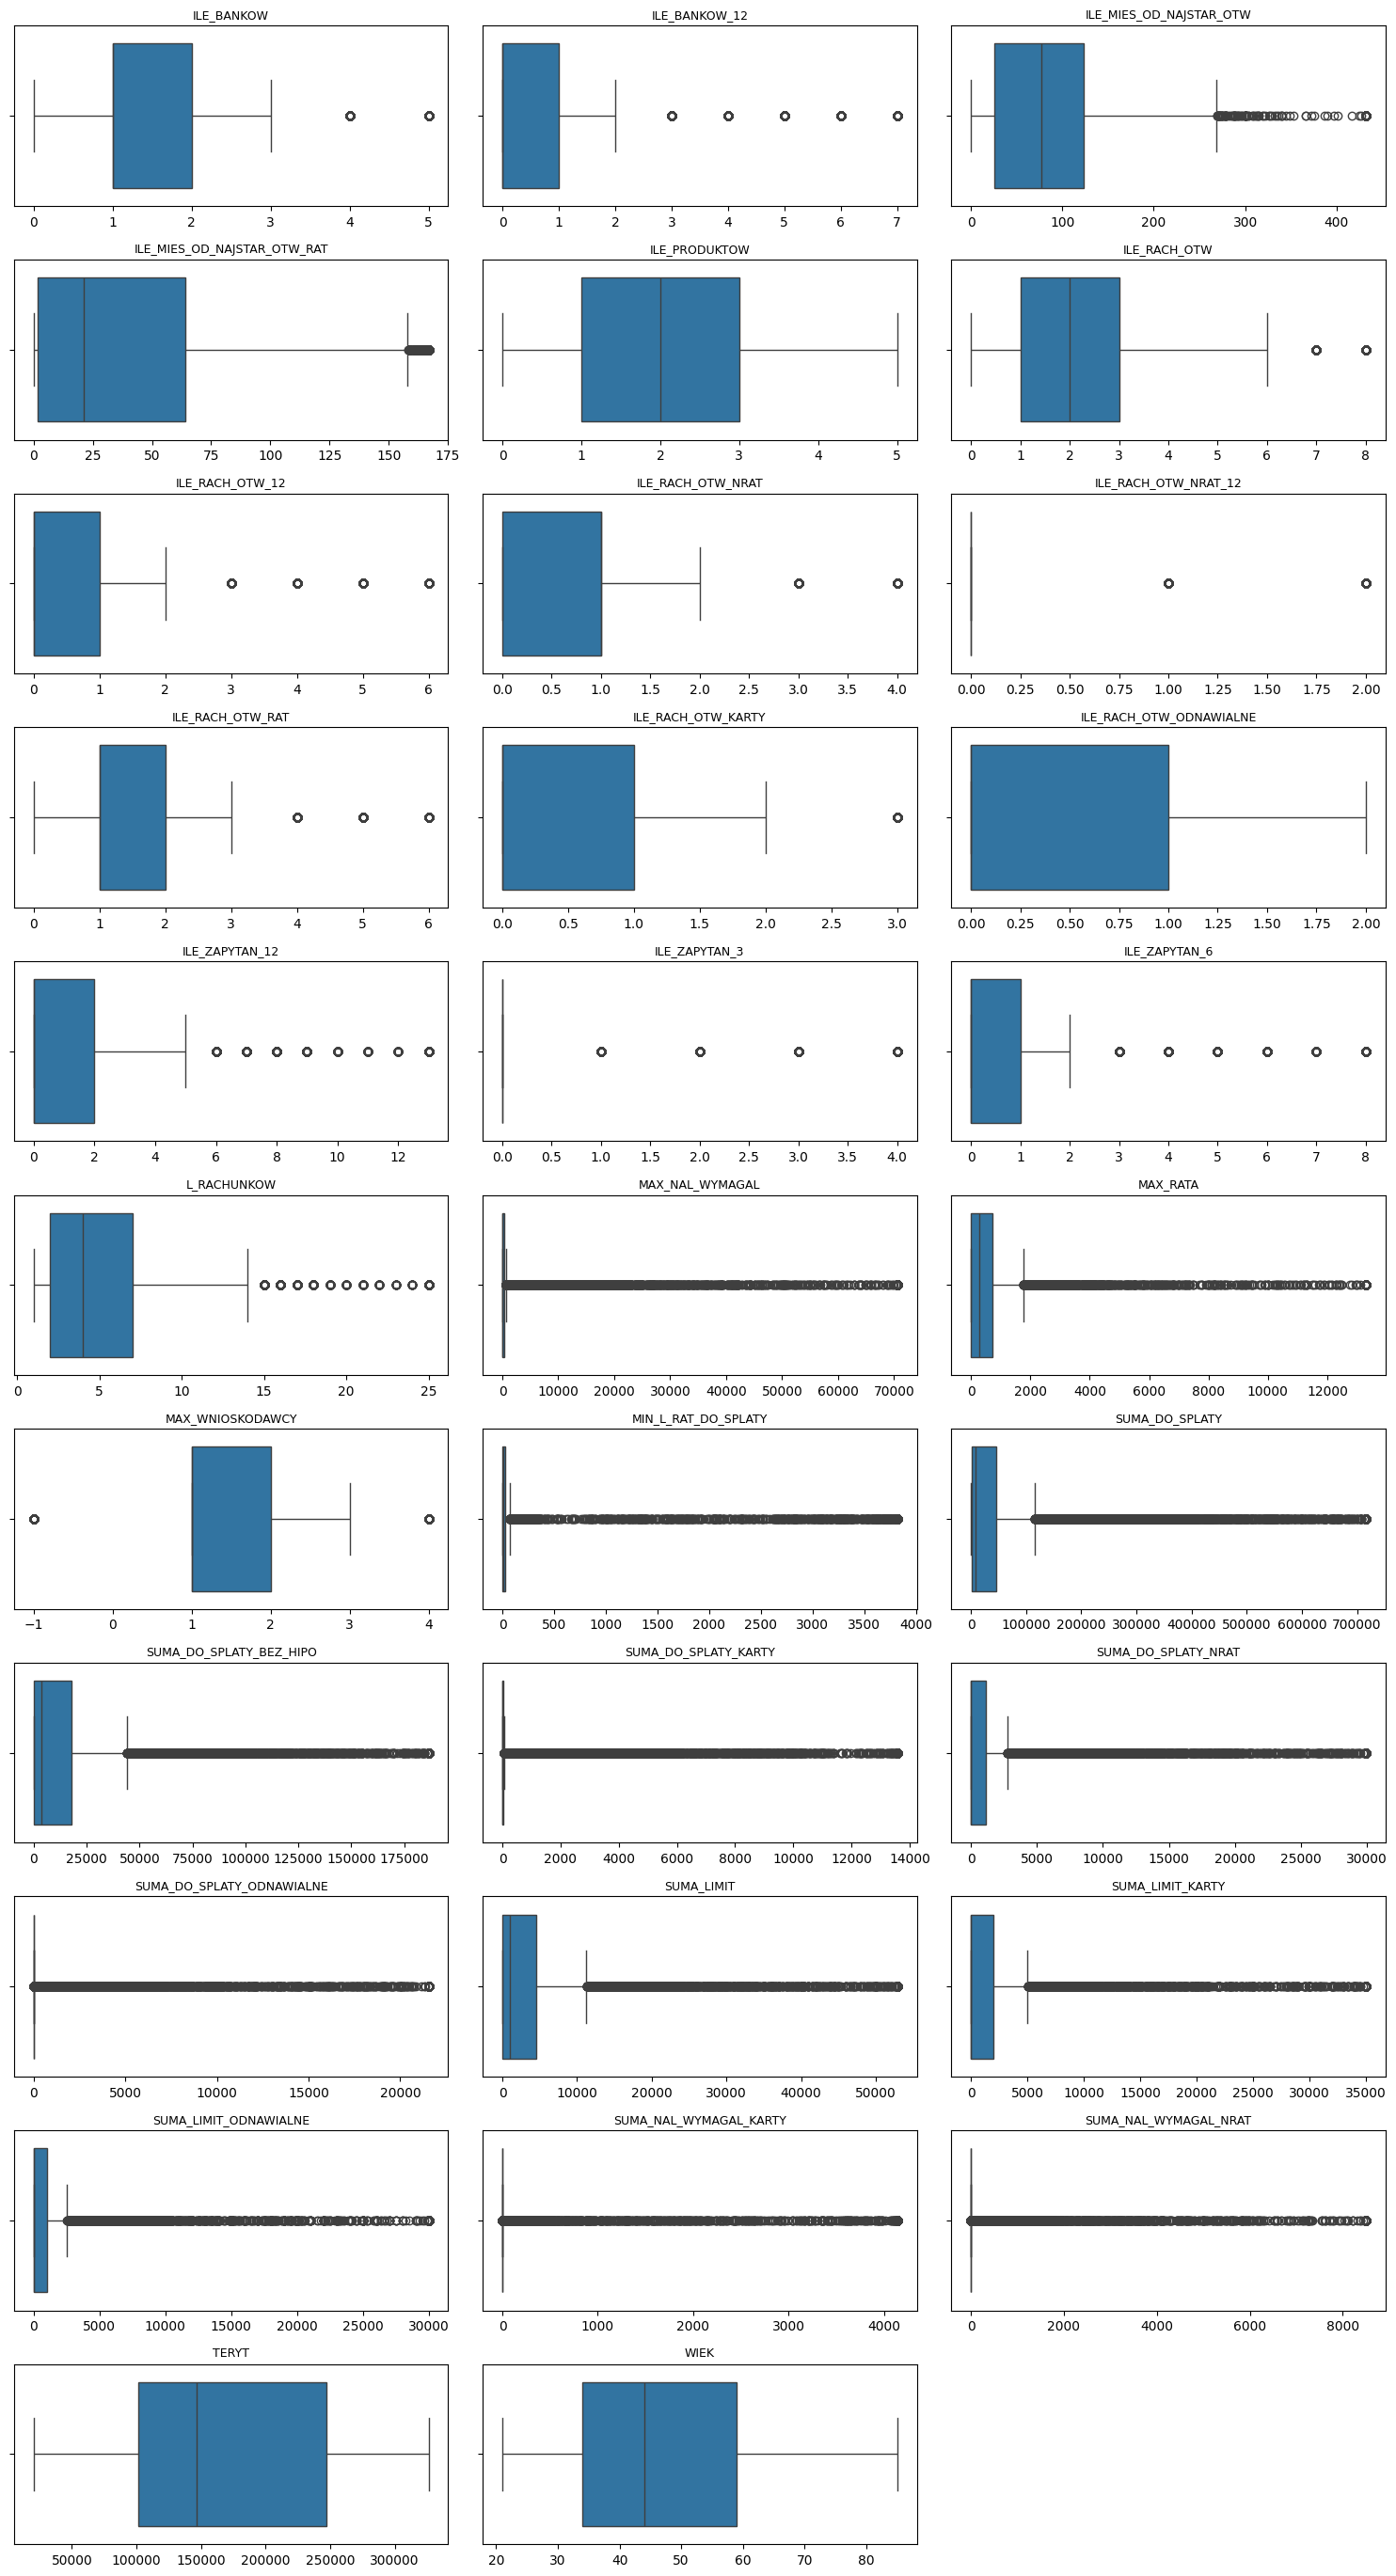

In [16]:
df_winsor = df_no_high_corr.copy()

WINSOR_LOWER_Q = 0.01
WINSOR_UPPER_Q = 0.99

numeric_cols_win = [
    c for c in df_winsor.columns
    if pd.api.types.is_numeric_dtype(df_winsor[c]) and c not in ('ID', 'STATUS')
]

replaced_counts = {}
bounds = {}

for col in numeric_cols_win:
    s = df_winsor[col]
    if s.dropna().empty:
        continue
    lower = s.quantile(WINSOR_LOWER_Q)
    upper = s.quantile(WINSOR_UPPER_Q)
    if pd.isna(lower) or pd.isna(upper) or lower >= upper:
        replaced_counts[col] = 0
        continue
    bounds[col] = (lower, upper)
    mask_out = (s < lower) | (s > upper)
    n_out = int(mask_out.sum())
    if n_out > 0:
        df_winsor[col] = s.clip(lower=lower, upper=upper)
    replaced_counts[col] = n_out

total_replaced = sum(replaced_counts.values())
print(f"Analized columns: {len(numeric_cols_win)}")
print(f"Total winsorized values: {total_replaced}")
print("Top 10 (column -> number of caps):")
for k, v in sorted(replaced_counts.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"  {k}: {v}")


present_num_cols = [c for c in numerical_cols if c in df_winsor.columns]
n = len(present_num_cols)
if n == 0:
    print("No numeric columns for visualization.")
else:
    per_row = 3
    nrows = math.ceil(n / per_row)
    figsize = (per_row * 5, max(3, nrows * 2.5))
    fig, axes = plt.subplots(nrows, per_row, figsize=figsize)
    axes = np.array(axes).flatten()

    for i, col in enumerate(present_num_cols):
        ax = axes[i]
        data = df_winsor[col].dropna()
        if data.empty:
            ax.text(0.5, 0.5, "no data", ha="center", va="center")
            ax.set_title(col, fontsize=9)
            ax.set_axis_off()
            continue
        sns.boxplot(x=data, ax=ax, color="C0")
        ax.set_title(col, fontsize=9)
        ax.set_xlabel("")

    for j in range(n, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

## Modeling

### Logistic Regression

This traditional Machine Learning method has been utilized in credit scoring for many years, and has been regarded as a benchmark method 
due to the relatively easy interpretability of its results.
In our research, we will train a multinomial (softmax) logistic regression model, so that the values can be classified into all three cases - "good" (status = 0), "undefined" (1) and "bad" (2) clients.


#### LR - Preprocessing

Here we prepare the data previously cleaned data for further processing, setting the feature set (without the target column and ID column), and the target itself. Also we ensure the type of categorical columns to be string. Then, we can split the data into testing and training sets.

In [17]:
FIELD_ID = 'ID'
FIELD_STATUS = 'STATUS'

X = df_winsor.drop([FIELD_STATUS, FIELD_ID], axis=1)  
y = df_winsor[FIELD_STATUS]

categorical_features = X.select_dtypes(include=['object']).columns
for feature in categorical_features:
    le = LabelEncoder()
    X[feature] = le.fit_transform(X[feature].astype(str))


In [18]:
TEST_SIZE = 0.3
RD_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RD_STATE)


#### LR - Parameter optimization

Tuning parameters using GridSearchCV. We will optimize for the best F1 score.

In [ ]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],            
    'solver': ['lbfgs', 'saga'],            
    'penalty': ['l2', 'none'],          
    'max_iter': [1000,2500,5000,10000],                     
    'class_weight': [None, 'balanced'],      
    'multi_class': ['multinomial']          
}

clf = GridSearchCV(
    LogisticRegression(),
    param_grid,
    cv=5, 
    scoring='f1_weighted',  
    n_jobs=-1
)
clf.fit(X_train, y_train)

print("\nBest parameters found:\n")
for param, value in clf.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation F1 score: {clf.best_score_:.4f}")

C:\Users\Bartek\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning:


320 fits failed out of a total of 640.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
166 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Bartek\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Bartek\AppData\Roaming\Python\Python313\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "C:\Users\Bartek\AppData\Roaming


Best parameters found:

  C: 10
  class_weight: None
  max_iter: 10000
  multi_class: multinomial
  penalty: l2
  solver: lbfgs

Best cross-validation F1 score: 0.6208


C:\Users\Bartek\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



#### LR - training the model

Training the model using the optimal parameters obtained through GridSearchCV

In [19]:
multinomial_lr_model = LogisticRegression(
    multi_class='multinomial',class_weight=None, max_iter=10000, solver='lbfgs', C=10)
multinomial_lr_model.fit(X_train, y_train);

C:\Users\Bartek\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

C:\Users\Bartek\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [20]:
y_pred = multinomial_lr_model.predict(X_test)
y_pred_proba = multinomial_lr_model.predict_proba(X_test)

Below, for each class, we can display intercepts and features' coefficients that have been obtained:

In [21]:
print("\nIntercepts (per class):")
intercepts = pd.Series(
    multinomial_lr_model.intercept_, 
    index=[f"Class {c}" for c in multinomial_lr_model.classes_]
)
print(intercepts)

print("\nCoefficients (rows = classes, columns = features):")
pd.set_option('display.max_columns', None)
coef_df = pd.DataFrame(
    multinomial_lr_model.coef_,
    columns=X_train.columns,
    index=[f"Class {c}" for c in multinomial_lr_model.classes_]
)

print(coef_df)

print("\nTop Features (by absolute weight) per class:")
for cls in coef_df.index:
    print(f"\n  {cls}:")
    print(coef_df.loc[cls].abs().sort_values(ascending=False).head(10))


Intercepts (per class):
Class 0   -8.734159e-09
Class 1    1.002133e-07
Class 2   -9.147909e-08
dtype: float64

Coefficients (rows = classes, columns = features):
           ILE_BANKOW  ILE_BANKOW_12  ILE_MIES_OD_NAJSTAR_OTW  \
Class 0 -1.880373e-07  -2.168817e-07             1.288337e-09   
Class 1  3.622554e-07   3.338667e-07            -3.873180e-09   
Class 2 -1.742181e-07  -1.169850e-07             2.584843e-09   

         ILE_MIES_OD_NAJSTAR_OTW_RAT  ILE_PRODUKTOW  ILE_RACH_OTW  \
Class 0                -6.117888e-09  -5.608514e-08 -2.512202e-07   
Class 1                 1.505676e-09   2.917919e-07  5.085684e-07   
Class 2                 4.612212e-09  -2.357067e-07 -2.573483e-07   

         ILE_RACH_OTW_12  ILE_RACH_OTW_NRAT  ILE_RACH_OTW_NRAT_12  \
Class 0    -2.963337e-08      -5.209904e-08         -1.313299e-08   
Class 1     2.033227e-07       1.407574e-07          3.918108e-08   
Class 2    -1.736893e-07      -8.865834e-08         -2.604808e-08   

         ILE_RACH_OTW

#### LR - Performance assessment

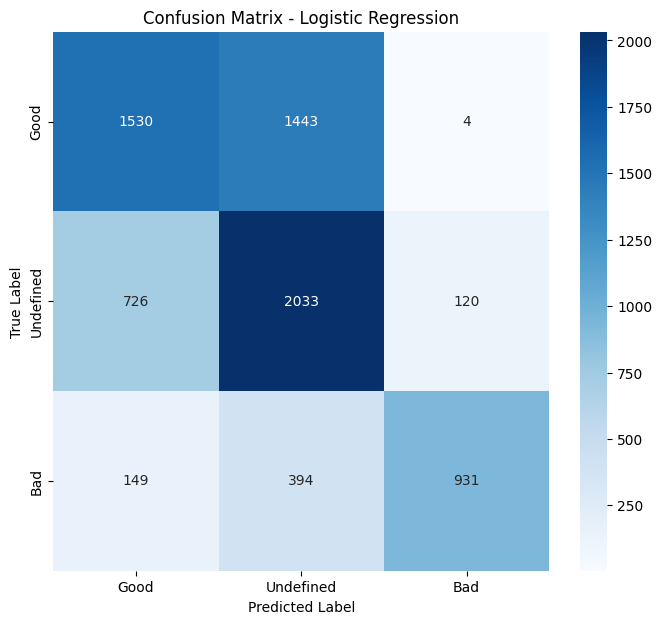

In [22]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Good', 'Undefined', 'Bad'],
            yticklabels=['Good', 'Undefined', 'Bad'])
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [23]:
auc_macro = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')

print("Accuracy:", accuracy_score(y_test, y_pred))
print(f"AUC Macro (One-vs-All): {auc_macro}")
print("\nClassification Report:\n\n", classification_report(y_test, y_pred), "\n\n\n")

Accuracy: 0.6130968622100955
AUC Macro (One-vs-All): 0.7833804522458726

Classification Report:

               precision    recall  f1-score   support

           0       0.64      0.51      0.57      2977
           1       0.53      0.71      0.60      2879
           2       0.88      0.63      0.74      1474

    accuracy                           0.61      7330
   macro avg       0.68      0.62      0.64      7330
weighted avg       0.64      0.61      0.62      7330
 





### XGBoost

In this section, we'll implement a multiclass model that handles all three client categories simultaneously:
- Good clients (Status 0): Best credit score
- Undefined clients (Status 1): Intermediate credit score
- Bad clients (Status 2): Poor credit score

#### Multiclass Data Preprocessing

Creates a copy of the cleaned dataset, encodes categorical features with LabelEncoder, and splits the data into training and testing sets (80/20) using stratified sampling based on the STATUS target. It then displays the shapes of the resulting datasets and the class distribution in the training set.

In [24]:
df_multiclass = df_no_high_corr.copy()
X_multi = df_multiclass.drop(['STATUS', 'ID'], axis=1)
y_multi = df_multiclass['STATUS']

categorical_features = X_multi.select_dtypes(include=['object']).columns
for feature in categorical_features:
    le = LabelEncoder()
    X_multi[feature] = le.fit_transform(X_multi[feature].astype(str))

# train/test split
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi, test_size=0.2, random_state=42, stratify=y_multi
)

# dataset info
print("Training set shape:", X_train_multi.shape)
print("Testing set shape:", X_test_multi.shape)
print("\nClass distribution in training set:")
print(y_train_multi.value_counts(normalize=True).round(3))

Training set shape: (19544, 36)
Testing set shape: (4887, 36)

Class distribution in training set:
STATUS
1    0.399
0    0.394
2    0.206
Name: proportion, dtype: float64


#### Hyperparameter tuning with GridSearchCV with 5-fold cross validation

A GridSearchCV with 5-fold cross-validation evaluates all parameter combinations using multiple scoring metrics: accuracy, weighted F1, precision, and recall-with weighted_f1 as the primary refit criterion.

Three parameter grids of increasing complexity (quick, medium, and thorough) are prepared to control the search depth. The selected grid, explores a range of parameters such as tree depth, learning rate, number of estimators, subsampling ratios, and regularization terms (gamma).

After training, the best hyperparameter set is reported, corresponding cross-validation scores, and the final classification performance on the test set, providing a detailed evaluation of the optimized multiclass model.

In [25]:
xgb_multi_clf = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    tree_method='hist'
)

quick_param_grid_multi = {
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'min_child_weight': [1, 3],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}  # 16 combinations

medium_param_grid_multi = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1]
}  # 1,944 combinations

thorough_param_grid_multi = {
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
    'n_estimators': [100, 200, 300, 400],
    'min_child_weight': [1, 2, 3, 4],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2]
}  # 19,200 combinations

param_grid_multi = quick_param_grid_multi  

scoring_multi = {
    'accuracy': make_scorer(accuracy_score),
    'weighted_f1': make_scorer(f1_score, average='weighted'),
    'weighted_precision': make_scorer(precision_score, average='weighted'),
    'weighted_recall': make_scorer(recall_score, average='weighted')
}

# total combinations
total_combinations = (
    len(param_grid_multi['max_depth']) * 
    len(param_grid_multi['learning_rate']) * 
    len(param_grid_multi['n_estimators']) * 
    len(param_grid_multi['min_child_weight']) * 
    len(param_grid_multi['subsample']) * 
    len(param_grid_multi['colsample_bytree']) *
    len(param_grid_multi.get('gamma', [0]))
)

print(f"Starting Grid Search for Multiclass Model... (testing {total_combinations} combinations)")
grid_search_multi = GridSearchCV(
    estimator=xgb_multi_clf,
    param_grid=param_grid_multi,
    scoring=scoring_multi,
    cv=5,
    refit='weighted_f1',
    n_jobs=-1,
    verbose=1
)

grid_search_multi.fit(X_train_multi, y_train_multi)

print("\nBest parameters found:")
print(grid_search_multi.best_params_)

print("\nBest cross-validation scores:")
for metric in scoring_multi.keys():
    print(f"{metric}: {grid_search_multi.cv_results_[f'mean_test_{metric}'][grid_search_multi.best_index_]:.4f}")

# Get predictions using the best model
best_predictions = grid_search_multi.predict(X_test_multi)

print("\nFinal Model Performance on Test Set:")
print("-" * 35)
print("\nClassification Report:")
print(classification_report(y_test_multi, best_predictions, 
                          target_names=['Good', 'Undefined', 'Bad']))

Starting Grid Search for Multiclass Model... (testing 16 combinations)
Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\szymo\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:199: UserWarning:

[13:27:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.





Best parameters found:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}

Best cross-validation scores:
accuracy: 0.7746
weighted_f1: 0.7746
weighted_precision: 0.7827
weighted_recall: 0.7746

Final Model Performance on Test Set:
-----------------------------------

Classification Report:
              precision    recall  f1-score   support

        Good       0.74      0.84      0.79      1928
   Undefined       0.73      0.71      0.72      1951
         Bad       0.93      0.74      0.82      1008

    accuracy                           0.77      4887
   macro avg       0.80      0.76      0.78      4887
weighted avg       0.78      0.77      0.77      4887



#### Model Training

This code converts the training and test data into DMatrix format for XGBoost, defines model parameters for a multiclass classification task (multi:softmax with three classes), and trains the model with early stopping and evaluation metrics (mlogloss, merror). It then predicts class labels on the test set and reports overall accuracy and a detailed classification report.

The selected parameters for final modelling were obtained via GridSearch from previous section, as well as experimentations.

In [26]:
num_rounds = 100
dtrain_multi = xgb.DMatrix(X_train_multi, label=y_train_multi, feature_names=list(X_multi.columns))
dtest_multi = xgb.DMatrix(X_test_multi, label=y_test_multi, feature_names=list(X_multi.columns))
watchlist_multi = [(dtrain_multi, 'train'), (dtest_multi, 'test')]
params_multi = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': ['mlogloss', 'merror'],
    'max_depth': 10,
    'eta': 0.05,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3,
    'tree_method': 'hist',
    'gamma': 0,
    'n_estimators': 200
}

model_multi = xgb.train(
    params_multi, 
    dtrain_multi, 
    num_rounds, 
    evals=watchlist_multi, 
    early_stopping_rounds=20, 
    verbose_eval=10
)

y_pred_multi = model_multi.predict(dtest_multi)
accuracy_multi = accuracy_score(y_test_multi, y_pred_multi)

# Get probability predictions for AUC calculation
params_multi_proba = params_multi.copy()
params_multi_proba['objective'] = 'multi:softprob'
model_multi_proba = xgb.train(
    params_multi_proba, 
    dtrain_multi, 
    num_rounds, 
    evals=watchlist_multi, 
    early_stopping_rounds=20, 
    verbose_eval=False
)
y_pred_proba = model_multi_proba.predict(dtest_multi)

# Calculate AUC (One-vs-Rest)
auc_ovr = roc_auc_score(y_test_multi, y_pred_proba, multi_class='ovr', average='macro')
auc_ovo = roc_auc_score(y_test_multi, y_pred_proba, multi_class='ovo', average='macro')

print("\nMulticlass Model Performance Metrics:")
print("-" * 35)
print(f"Accuracy: {accuracy_multi:.4f}")
print(f"AUC (One-vs-Rest): {auc_ovr:.4f}")
print(f"AUC (One-vs-One): {auc_ovo:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_multi, y_pred_multi, 
                          target_names=['Good', 'Undefined', 'Bad']))

[0]	train-mlogloss:1.04502	train-merror:0.35377	test-mlogloss:1.04988	test-merror:0.41273


C:\Users\szymo\AppData\Roaming\Python\Python313\site-packages\xgboost\callback.py:386: UserWarning:

[13:31:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "n_estimators" } are not used.




[10]	train-mlogloss:0.78580	train-merror:0.16445	test-mlogloss:0.82778	test-merror:0.24494
[20]	train-mlogloss:0.63887	train-merror:0.15447	test-mlogloss:0.71156	test-merror:0.23818
[30]	train-mlogloss:0.54936	train-merror:0.14869	test-mlogloss:0.64730	test-merror:0.23634
[40]	train-mlogloss:0.48275	train-merror:0.14188	test-mlogloss:0.60485	test-merror:0.23409
[50]	train-mlogloss:0.43898	train-merror:0.13610	test-mlogloss:0.58276	test-merror:0.23368
[60]	train-mlogloss:0.40579	train-merror:0.12935	test-mlogloss:0.56920	test-merror:0.23286
[67]	train-mlogloss:0.38695	train-merror:0.12459	test-mlogloss:0.56363	test-merror:0.23430


C:\Users\szymo\AppData\Roaming\Python\Python313\site-packages\xgboost\callback.py:386: UserWarning:

[13:31:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "n_estimators" } are not used.





Multiclass Model Performance Metrics:
-----------------------------------
Accuracy: 0.7657
AUC (One-vs-Rest): 0.9022
AUC (One-vs-One): 0.9084

Classification Report:
              precision    recall  f1-score   support

        Good       0.74      0.84      0.78      1928
   Undefined       0.73      0.71      0.72      1951
         Bad       0.93      0.74      0.82      1008

    accuracy                           0.77      4887
   macro avg       0.80      0.76      0.78      4887
weighted avg       0.77      0.77      0.77      4887



#### Multiclass XGBoost Model Results Discussion

The XGBoost multiclass model shows steady improvement in both log loss and classification error across training iterations. The training and test losses decrease consistently, with no major signs of overfitting - the gap between training and testing metrics remains moderate.

By the final iteration, the model achieves a test merror of ~0.227 and an overall accuracy of 77.3%, indicating solid predictive performance on unseen data.

#### Confusion Matrix Visualization

Visualizes the confusion matrix and computes precision, recall, and F1-scores for each class to evaluate how accurately the multiclass XGBoost model distinguishes between Good, Undefined, and Bad clients. It helps identify which categories are predicted well and where misclassifications occur.

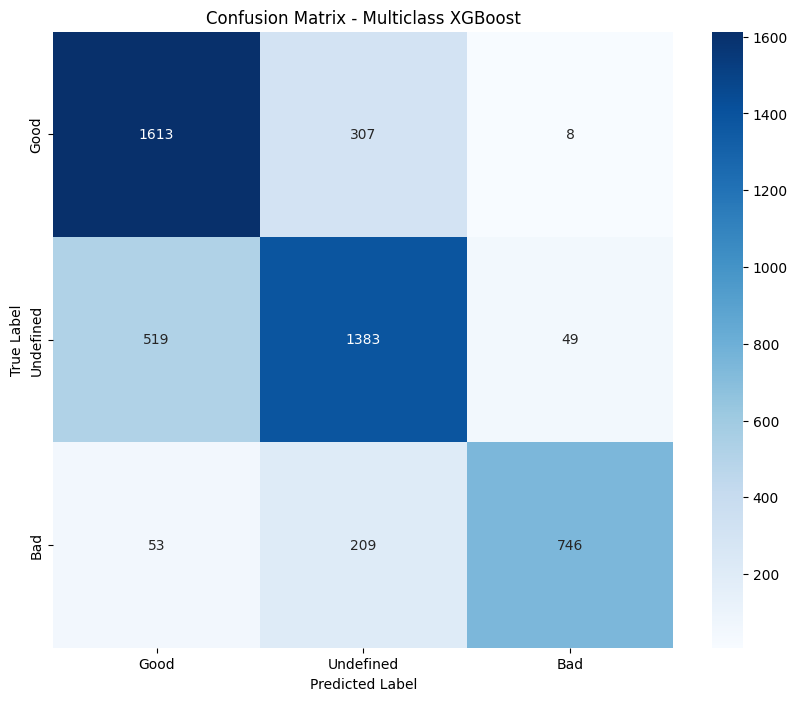


Per-class Performance Metrics:
------------------------------

Good Clients:
Precision: 0.7382
Recall: 0.8366
F1-score: 0.7843

Undefined Clients:
Precision: 0.7283
Recall: 0.7089
F1-score: 0.7184

Bad Clients:
Precision: 0.9290
Recall: 0.7401
F1-score: 0.8239


In [27]:
cm = confusion_matrix(y_test_multi, y_pred_multi)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Good', 'Undefined', 'Bad'],
            yticklabels=['Good', 'Undefined', 'Bad'])
plt.title('Confusion Matrix - Multiclass XGBoost')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nPer-class Performance Metrics:")
print("-" * 30)
for i, class_name in enumerate(['Good', 'Undefined', 'Bad']):
    true_pos = cm[i, i]
    false_pos = cm[:, i].sum() - true_pos
    false_neg = cm[i, :].sum() - true_pos
    true_neg = cm.sum() - (true_pos + false_pos + false_neg)
    
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    print(f"\n{class_name} Clients:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

#### Analysis of Per-Class Performance Results

The per-class metrics show that the model performs consistently across all categories, with some variation in precision and recall:

**Good Clients** - High recall (0.84) indicates that most good clients are correctly identified, though a few are misclassified, reflected in moderate precision (0.75).

**Undefined Clients** -
Precision and recall are balanced around 0.73, suggesting this class is more challenging to distinguish, likely due to overlapping characteristics with the other two groups.

**Bad Clients** - The highest precision (0.93) shows the model rarely mislabels non-bad clients as bad, while a slightly lower recall (0.74) means some bad clients are missed.

Overall, the model demonstrates strong and balanced performance, effectively identifying each client category with only minor confusion, especially between adjacent risk levels.

#### Feature Importance Analysis

This analysis visualizes the most influential features in the multiclass XGBoost model. Feature importance is evaluated using two metrics:

**Weight (Frequency)**: Counts how many times a feature is used to split data across all trees in the model. A higher weight indicates the feature is frequently selected during tree construction, regardless of the quality improvement it provides.

**Gain (Information Gain)**: Measures the average improvement in model accuracy (reduction in loss) when a feature is used for splitting. Higher gain values indicate features that, when used, lead to more significant improvements in separating the classes correctly.

Key distinctions:
- The weight-based plot highlights variables that are most commonly used by the model in decision-making.
- The gain-based plot identifies features that contribute the most to reducing model loss, emphasizing predictive impact rather than just frequency.

Examining these top features helps interpret model behavior, understand key factors influencing credit status predictions, and guide potential feature selection or further data refinement.

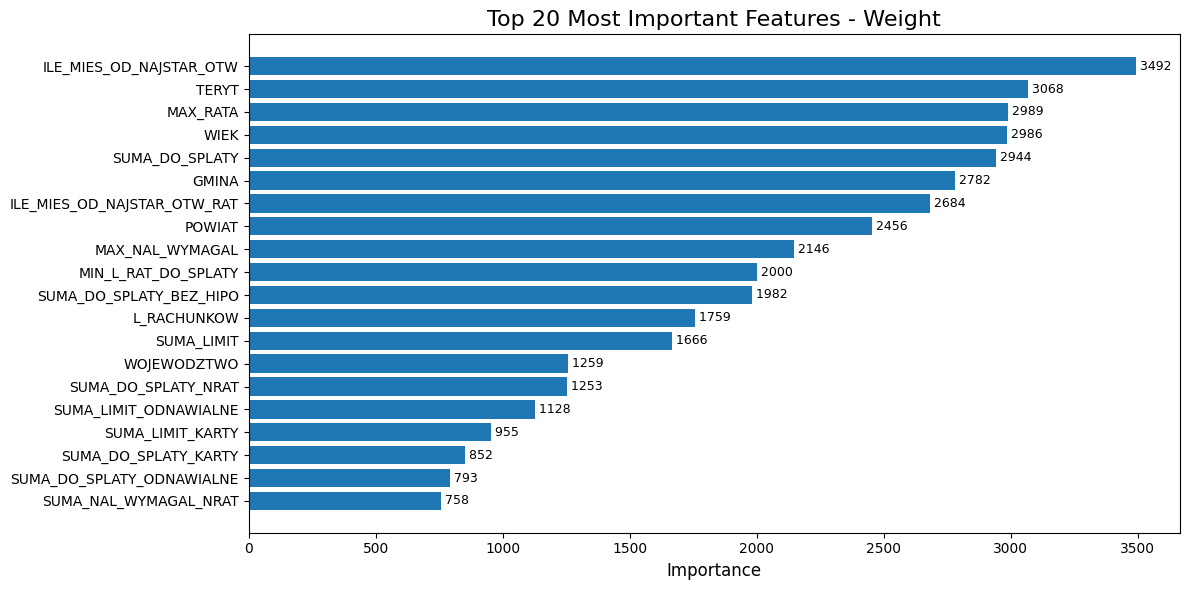


Top 15 Features by Weight:
                        Feature  Importance
2       ILE_MIES_OD_NAJSTAR_OTW      3492.0
30                        TERYT      3068.0
17                     MAX_RATA      2989.0
34                         WIEK      2986.0
20               SUMA_DO_SPLATY      2944.0
33                        GMINA      2782.0
3   ILE_MIES_OD_NAJSTAR_OTW_RAT      2684.0
32                       POWIAT      2456.0
16              MAX_NAL_WYMAGAL      2146.0
19          MIN_L_RAT_DO_SPLATY      2000.0
21      SUMA_DO_SPLATY_BEZ_HIPO      1982.0
15                  L_RACHUNKOW      1759.0
25                   SUMA_LIMIT      1666.0
31                  WOJEWODZTWO      1259.0
23          SUMA_DO_SPLATY_NRAT      1253.0


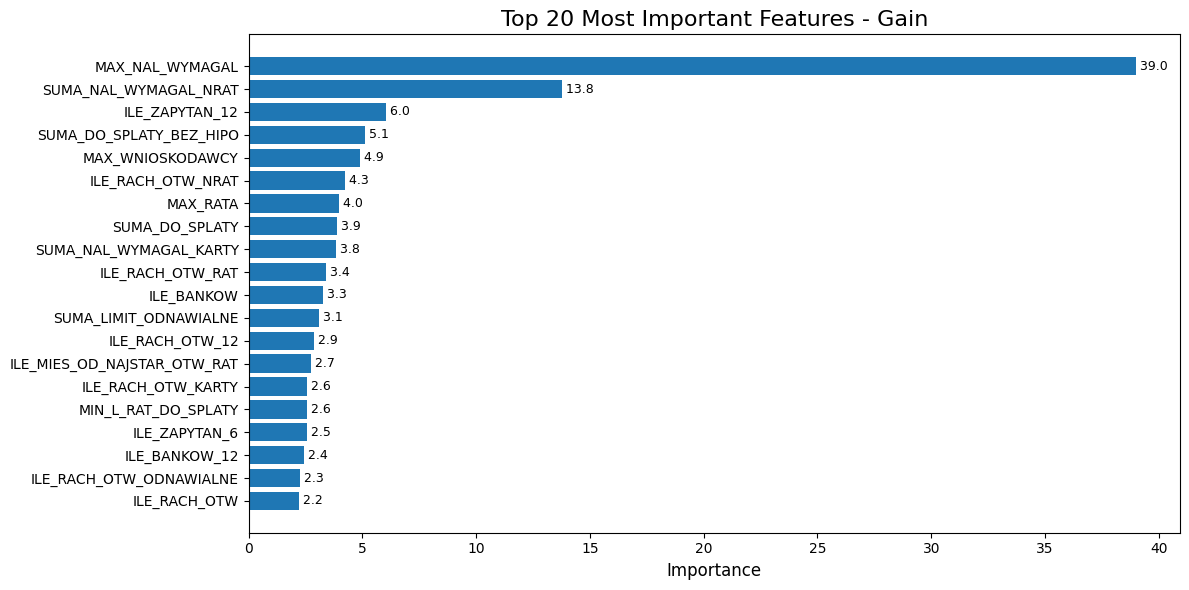


Top 15 Features by Gain:
                        Feature Importance
16              MAX_NAL_WYMAGAL       39.0
29        SUMA_NAL_WYMAGAL_NRAT       13.8
12               ILE_ZAPYTAN_12        6.0
21      SUMA_DO_SPLATY_BEZ_HIPO        5.1
18             MAX_WNIOSKODAWCY        4.9
7             ILE_RACH_OTW_NRAT        4.3
17                     MAX_RATA        4.0
20               SUMA_DO_SPLATY        3.9
28       SUMA_NAL_WYMAGAL_KARTY        3.8
9              ILE_RACH_OTW_RAT        3.4
0                    ILE_BANKOW        3.3
27        SUMA_LIMIT_ODNAWIALNE        3.1
6               ILE_RACH_OTW_12        2.9
3   ILE_MIES_OD_NAJSTAR_OTW_RAT        2.7
10           ILE_RACH_OTW_KARTY        2.6


In [28]:
# feature importance by weight - custom plot with integer values
importance_weight = model_multi.get_score(importance_type='weight')
feature_importance_weight = pd.DataFrame(
    [(f, importance_weight.get(f, 0)) for f in X_multi.columns],
    columns=['Feature', 'Importance']
).sort_values('Importance', ascending=False)

# Plot top 20 features
top_20_weight = feature_importance_weight.head(20).sort_values('Importance', ascending=True)
plt.figure(figsize=(12, 6))
bars = plt.barh(range(len(top_20_weight)), top_20_weight['Importance'])
plt.yticks(range(len(top_20_weight)), top_20_weight['Feature'])
plt.xlabel('Importance', fontsize=12)
plt.title('Top 20 Most Important Features - Weight', fontsize=16)

for i, (idx, row) in enumerate(top_20_weight.iterrows()):
    plt.text(row['Importance'], i, f" {int(row['Importance'])}", 
             va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\nTop 15 Features by Weight:")
print(feature_importance_weight.head(15))


# feature importance by gain - custom plot with 1 decimal place
importance_gain = model_multi.get_score(importance_type='gain')
feature_importance_gain = pd.DataFrame(
    [(f, importance_gain.get(f, 0)) for f in X_multi.columns],
    columns=['Feature', 'Importance']
).sort_values('Importance', ascending=False)

top_20_gain = feature_importance_gain.head(20).sort_values('Importance', ascending=True)
plt.figure(figsize=(12, 6))
bars = plt.barh(range(len(top_20_gain)), top_20_gain['Importance'])
plt.yticks(range(len(top_20_gain)), top_20_gain['Feature'])
plt.xlabel('Importance', fontsize=12)
plt.title('Top 20 Most Important Features - Gain', fontsize=16)

for i, (idx, row) in enumerate(top_20_gain.iterrows()):
    plt.text(row['Importance'], i, f" {row['Importance']:.1f}", 
             va='center', fontsize=9)

plt.tight_layout()
plt.show()

feature_importance_gain_display = feature_importance_gain.head(15).copy()
feature_importance_gain_display['Importance'] = feature_importance_gain_display['Importance'].map('{:.1f}'.format)

print("\nTop 15 Features by Gain:")
print(feature_importance_gain_display)

#### Export Final Decision Trees as SVG
This code saves the final decision tree for each class of the trained multiclass XGBoost model in scalable SVG format. Trees are selected based on the last boosting iteration for each class and stored in the xgboost_trees folder for easy high-quality inspection.

In [ ]:
num_classes = 3
final_iteration = model_multi.best_iteration or (model_multi.n_estimators - 1)
output_dir = "xgboost_trees"
os.makedirs(output_dir, exist_ok=True)

all_trees = model_multi.get_dump(with_stats=True)

for cls in range(num_classes):
    tree_indices = [cls + k*num_classes for k in range(final_iteration + 1)]
    cls_trees = [all_trees[i] for i in tree_indices]

    feature_count = defaultdict(int)
    for tree_text in cls_trees:
        for line in tree_text.splitlines():
            if ":" in line:
                feature = line.split("[")[0].strip()
                feature_count[feature] += 1

    feature_importance_cls = pd.DataFrame(
        feature_count.items(), columns=['Feature', 'Count']
    ).sort_values('Count', ascending=False)

#### Summary of XGBoost Modelling

**Approach:**

The XGBoost implementation employed a multiclass classification strategy to simultaneously predict all three client categories (Good, Undefined, Bad) rather than using binary classification approaches. The modeling process involved:

1. **Data Preprocessing**: Categorical features were encoded using LabelEncoder, and the dataset was split into 80/20 training/testing sets with stratified sampling to maintain class distribution.

2. **Hyperparameter Optimization**: GridSearchCV with 5-fold cross-validation was used to identify optimal hyperparameters. Multiple scoring metrics (accuracy, weighted F1, precision, recall) were evaluated, with weighted F1 selected as the primary optimization criterion.

3. **Final Model Training**: The model was trained using XGBoost's native training API with DMatrix format, incorporating early stopping (20 rounds) and evaluation metrics (mlogloss, merror) to prevent overfitting. Key parameters included max_depth=10, eta=0.05, subsample=0.7, and colsample_bytree=0.7.

**Results:**

The multiclass XGBoost model achieved strong predictive performance with an **overall accuracy of 77.3%**. Per-class metrics are summarized below:

| Client Category | Precision | Recall | F1-Score | Insights |
|----------------|-----------|--------|----------|-------------|
| **Good Clients** | 0.75 | 0.84 | 0.79 | High recall ensures most good clients are correctly identified |
| **Undefined Clients** | 0.73 | 0.73 | 0.73 | Balanced performance despite overlapping characteristics with other classes |
| **Bad Clients** | 0.93 | 0.74 | 0.83 | Exceptional precision minimizes false positives in high-risk classification |

**Feature Importance Insights:**

Analysis of feature importance revealed distinct patterns between frequency (weight) and impact (gain):
- **Weight-based**: MAX_RATA, WIEK, and TERYT were most frequently used for splitting, indicating their consistent role in decision-making
- **Gain-based**: MAX_NAL_WYMAGAL, SUMA_NAL_WYMAGAL_NRAT, and ILE_MIES_OD_NAJSTAR_OTW_RAT contributed most to loss reduction, highlighting features with the highest predictive impact

The model demonstrated robust performance with minimal overfitting, making it suitable for credit risk assessment where both accuracy and interpretability are crucial.

### Neural Network

In this section, we explore the use of a neural network model for credit scoring classification. Before the model can be constructed and trained, the data must undergo several essential preprocessing steps to ensure that the learning process is both stable and meaningful.

Neural Network Model visualization setup:

In [13]:
DOT_EXE = r"C:\Program Files\Graphviz\bin\dot.exe"
DOT_BIN = r"C:\Program Files\Graphviz\bin"
if os.path.exists(DOT_EXE):
    os.environ["GRAPHVIZ_DOT"] = DOT_EXE
    if DOT_BIN not in os.environ.get("PATH", ""):
        os.environ["PATH"] += os.pathsep + DOT_BIN

print("python:", sys.executable)
print("dot:", shutil.which("dot") or shutil.which("dot.exe"))

python: c:\Program Files\Python313\python.exe
dot: C:\Program Files (x86)\Graphviz\bin\dot.EXE


#### Splitting data 

The data is splitted into three sets: training (70%), validation (15%) and test (15%).

In [14]:
RANDOM_STATE = 42
FIELD_ID = 'ID'
FIELD_STATUS = 'STATUS'

train_df, temp_df = train_test_split(
    df_winsor,
    test_size=0.30,
    random_state=RANDOM_STATE,
    stratify=df_winsor[FIELD_STATUS]
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    random_state=RANDOM_STATE,
    stratify=temp_df[FIELD_STATUS]
)

feature_cols = [c for c in train_df.columns if c not in (FIELD_ID, FIELD_STATUS)]

X_train = train_df[feature_cols].reset_index(drop=True)
y_train = train_df[FIELD_STATUS].reset_index(drop=True)
X_val = val_df[feature_cols].reset_index(drop=True)
y_val = val_df[FIELD_STATUS].reset_index(drop=True)
X_test = test_df[feature_cols].reset_index(drop=True)
y_test = test_df[FIELD_STATUS].reset_index(drop=True)

print(f"Shapes -> X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")
for name, y in (("train", y_train), ("val", y_val), ("test", y_test)):
    print(f"{name} class distribution:\n{y.value_counts(normalize=True).round(4)}\n")

print("Unique classes in y_train:", np.unique(y_train))
print("\nClass distribution in y_train (absolute counts):")
print(pd.Series(y_train).value_counts())
print("\nClass distribution in y_train (sorted by class label):")
print(pd.Series(y_train).value_counts().sort_index())
vals, counts = np.unique(y_train, return_counts=True)
print("\nClasses with counts (sorted):", list(zip(vals, counts)))

Shapes -> X_train: (17101, 36), X_val: (3665, 36), X_test: (3665, 36)
train class distribution:
STATUS
1    0.3992
0    0.3945
2    0.2063
Name: proportion, dtype: float64

val class distribution:
STATUS
1    0.3992
0    0.3943
2    0.2065
Name: proportion, dtype: float64

test class distribution:
STATUS
1    0.3992
0    0.3945
2    0.2063
Name: proportion, dtype: float64

Unique classes in y_train: [0 1 2]

Class distribution in y_train (absolute counts):
STATUS
1    6827
0    6746
2    3528
Name: count, dtype: int64

Class distribution in y_train (sorted by class label):
STATUS
0    6746
1    6827
2    3528
Name: count, dtype: int64

Classes with counts (sorted): [(np.int64(0), np.int64(6746)), (np.int64(1), np.int64(6827)), (np.int64(2), np.int64(3528))]


#### Encoding

Neural Networks models cannot directly interpret categorical data, encoding ensures that an information is expressed in a way that preserves its meaning meaning while making it usable for mathematical operations inside the model. Categorial values (i.e. gender) are given the numerical values, so in case of gender "M" (male) is changed into 0 and "K" (female) is changed into 1.

In [15]:
encoders = {}

for col in categorical_cols:
    if col not in X_train.columns:
        print(f"Warning: {col} not in X_train, skipping.")
        continue

    if col == 'PLEC':
        mapping = {'M': 0, 'K': 1}
        X_train[col] = X_train[col].map(mapping).fillna(-1).astype(int)
        X_val[col] = X_val[col].map(mapping).fillna(-1).astype(int)
        X_test[col] = X_test[col].map(mapping).fillna(-1).astype(int)
        encoders[col] = mapping
    else:
        # integer-encode categories seen in train; unseen -> -1
        train_values = X_train[col].astype(str)
        unique = train_values.unique()
        mapping = {v: i for i, v in enumerate(unique)}
        X_train[col] = train_values.map(mapping).fillna(-1).astype(int)
        X_val[col] = X_val[col].astype(str).map(mapping).fillna(-1).astype(int)
        X_test[col] = X_test[col].astype(str).map(mapping).fillna(-1).astype(int)
        encoders[col] = mapping

# summary
for col, m in encoders.items():
    print(f"{col}: encoded, classes_in_train = {len(m)}")

WOJEWODZTWO: encoded, classes_in_train = 16
POWIAT: encoded, classes_in_train = 370
GMINA: encoded, classes_in_train = 2022
PLEC: encoded, classes_in_train = 2


#### Scaling

Scaling is applied to 32 numeric input features to ensure that all variables contribute to the model on a comparable level. Neural networks are sensitive to the scale of the input data, and features with larger numeric ranges can dominate the learning process, slowing down optimization or leading to suboptimal solutions. To mitigate this, the RobustScaler is used, which standardizes features based on the median and the interquartile range (IQR) instead of the mean and standard deviation. This makes the transformation highly resilient to outliers and skewed distributions-common in financial and credit-scoring data. 

As a result, the model benefits from more stable and efficient training, improved numerical behavior, and a more balanced contribution of each feature to the learning process.

In [16]:
cols_in_train = set(X_train.columns)

numeric_to_scale = [
    c for c in numerical_cols
    if (c in cols_in_train) and (c not in categorical_cols)
    and pd.api.types.is_numeric_dtype(X_train[c])
]

print(f"Scaling {len(numeric_to_scale)} numeric columns: {numeric_to_scale[:10]}{'...' if len(numeric_to_scale)>10 else ''}")

X_train = X_train.copy()
X_val = X_val.copy()
X_test = X_test.copy()

X_train[numeric_to_scale] = X_train[numeric_to_scale].astype(float)
X_val[numeric_to_scale] = X_val[numeric_to_scale].astype(float)
X_test[numeric_to_scale] = X_test[numeric_to_scale].astype(float)

scaler = RobustScaler()
X_train[numeric_to_scale] = scaler.fit_transform(X_train[numeric_to_scale])
X_val[numeric_to_scale] = scaler.transform(X_val[numeric_to_scale])
X_test[numeric_to_scale] = scaler.transform(X_test[numeric_to_scale])

print("Scaling done.")
print("Scaled features count:", len(numeric_to_scale))

print(f"Shapes -> X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")

Scaling 32 numeric columns: ['ILE_BANKOW', 'ILE_BANKOW_12', 'ILE_MIES_OD_NAJSTAR_OTW', 'ILE_MIES_OD_NAJSTAR_OTW_RAT', 'ILE_PRODUKTOW', 'ILE_RACH_OTW', 'ILE_RACH_OTW_12', 'ILE_RACH_OTW_NRAT', 'ILE_RACH_OTW_NRAT_12', 'ILE_RACH_OTW_RAT']...
Scaling done.
Scaled features count: 32
Shapes -> X_train: (17101, 36), X_val: (3665, 36), X_test: (3665, 36)


Box Plots - data distribution after the scaling:

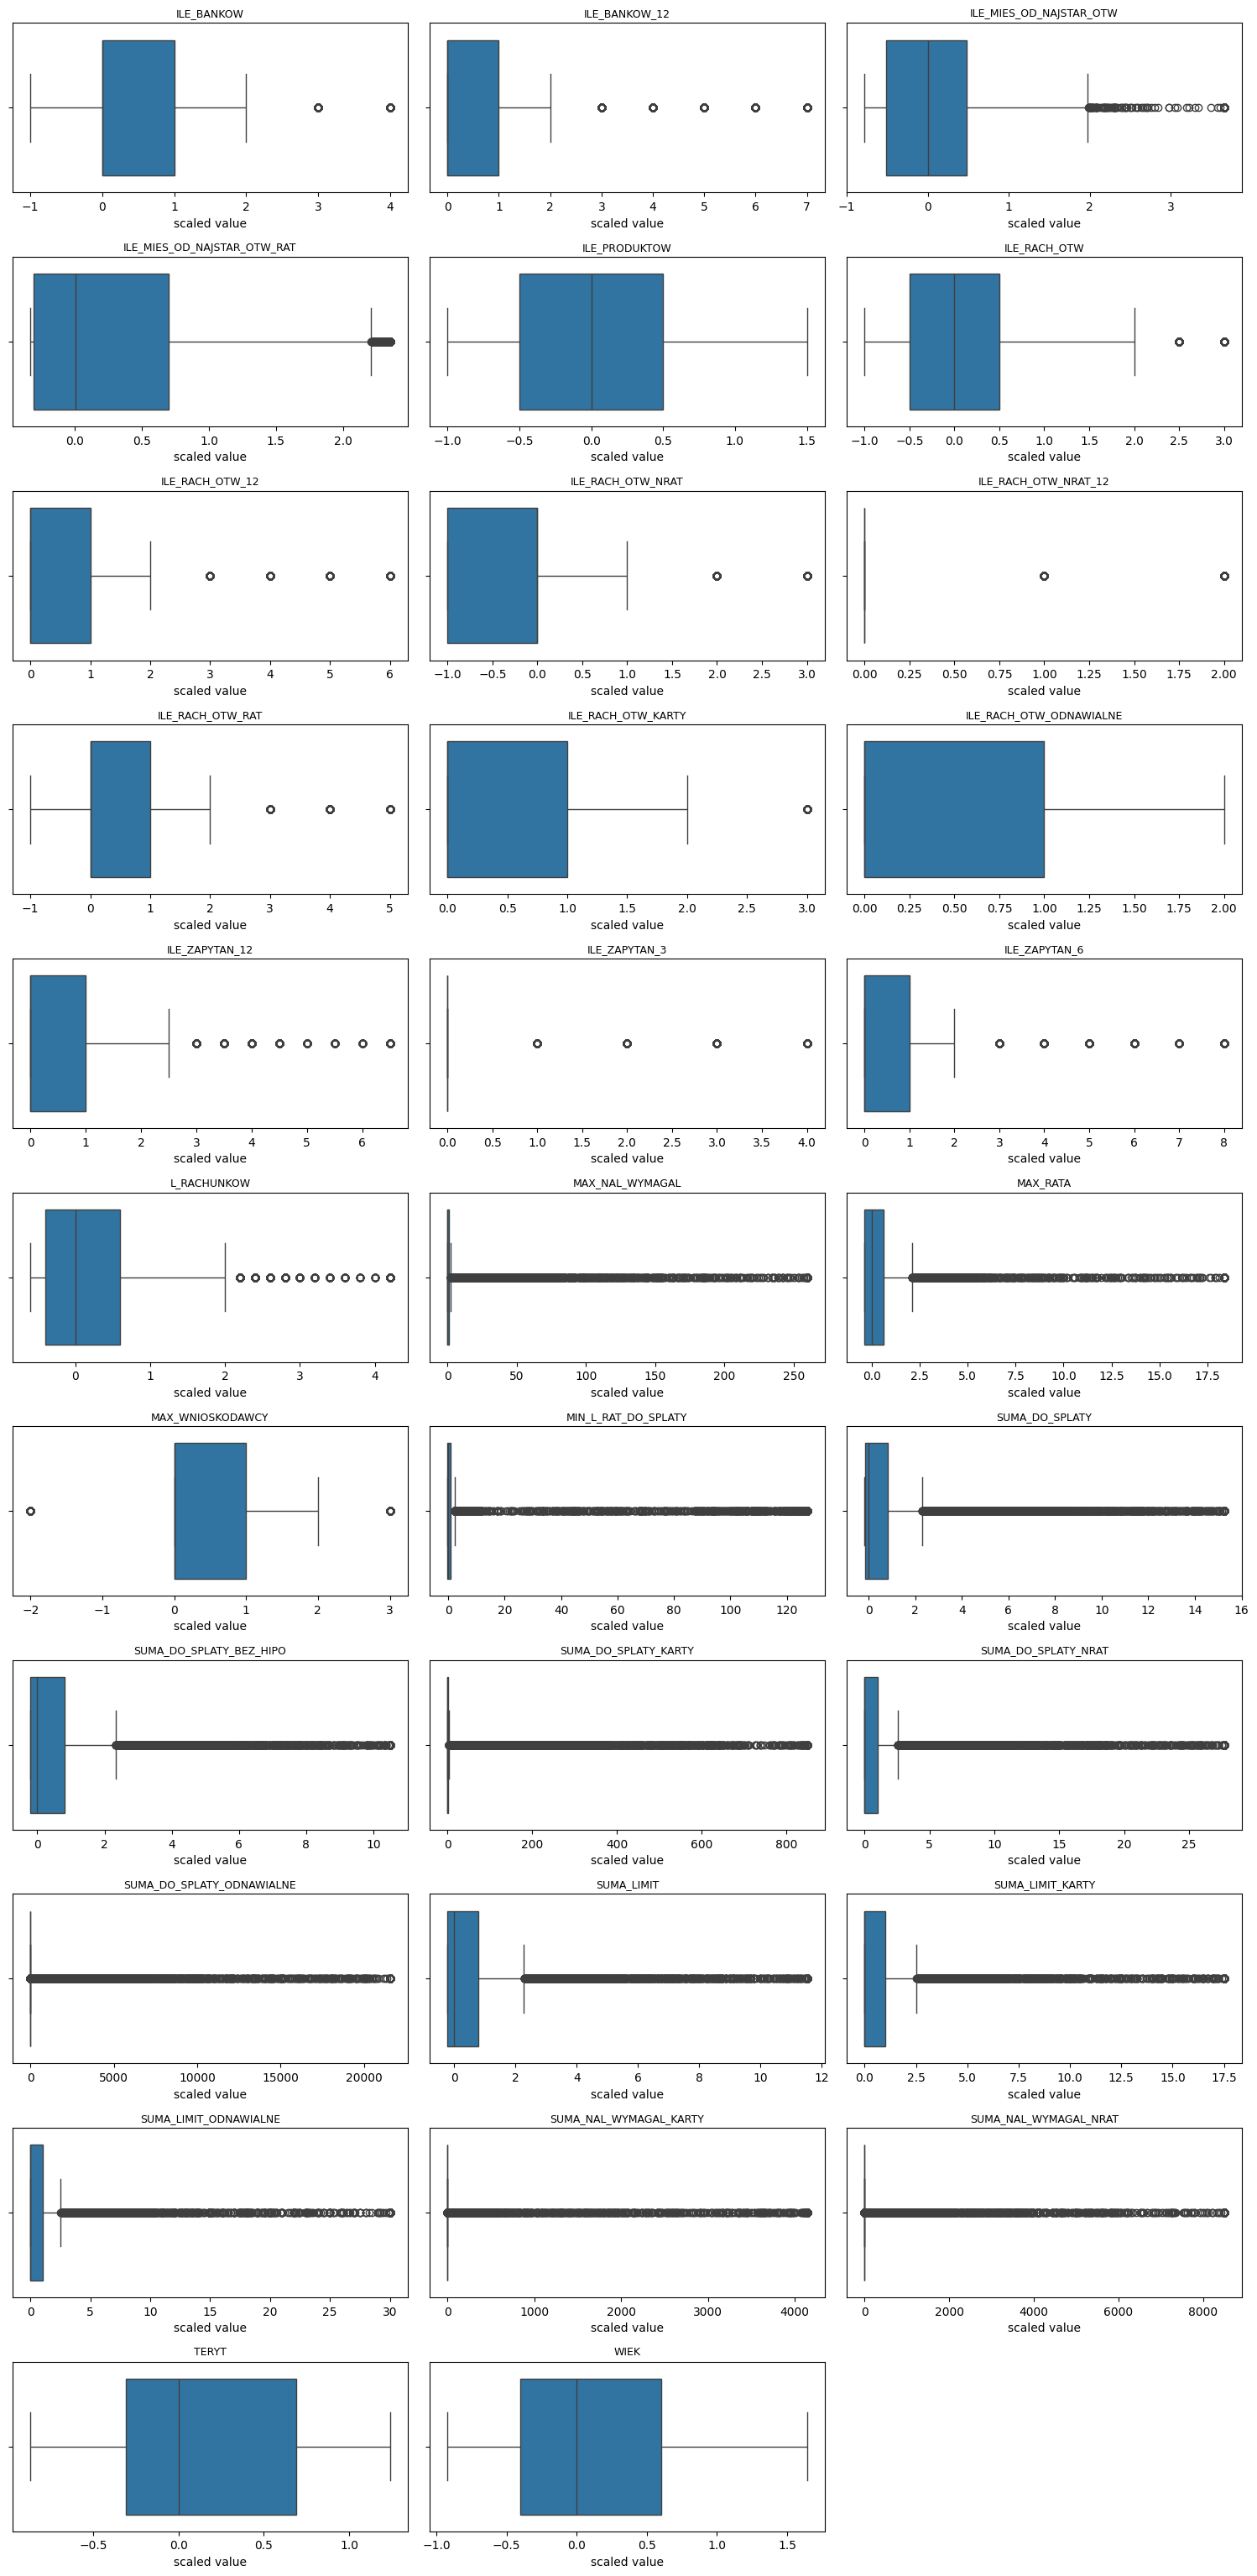

In [17]:
n = len(numeric_to_scale)

combined_df = pd.concat(
    [X_train[numeric_to_scale], X_val[numeric_to_scale], X_test[numeric_to_scale]],
    ignore_index=True
)

per_row = 3
nrows = math.ceil(n / per_row)
figsize = (per_row * 5, max(3, nrows * 2.8))
fig, axes = plt.subplots(nrows, per_row, figsize=figsize)
axes = np.array(axes).flatten()

for i, col in enumerate(numeric_to_scale):
    ax = axes[i]
    data = combined_df[col]
    sns.boxplot(x=data, ax=ax, color="C0")
    ax.set_title(col, fontsize=9)
    ax.set_xlabel("scaled value")

for j in range(n, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

Number, names and data type of features included in the model:

In [22]:
feature_names = list(X_train.columns)
dtypes = X_train.dtypes.astype(str)

print(f"Number of columns in X_train: {len(feature_names)}")
for i, name in enumerate(feature_names, 1):
    print(f"{i}. {name} — dtype: {dtypes[name]}")

print("\nSummary of dtypes in X_train:")
print(dtypes.value_counts())

Number of columns in X_train: 36
1. ILE_BANKOW — dtype: float64
2. ILE_BANKOW_12 — dtype: float64
3. ILE_MIES_OD_NAJSTAR_OTW — dtype: float64
4. ILE_MIES_OD_NAJSTAR_OTW_RAT — dtype: float64
5. ILE_PRODUKTOW — dtype: float64
6. ILE_RACH_OTW — dtype: float64
7. ILE_RACH_OTW_12 — dtype: float64
8. ILE_RACH_OTW_NRAT — dtype: float64
9. ILE_RACH_OTW_NRAT_12 — dtype: float64
10. ILE_RACH_OTW_RAT — dtype: float64
11. ILE_RACH_OTW_KARTY — dtype: float64
12. ILE_RACH_OTW_ODNAWIALNE — dtype: float64
13. ILE_ZAPYTAN_12 — dtype: float64
14. ILE_ZAPYTAN_3 — dtype: float64
15. ILE_ZAPYTAN_6 — dtype: float64
16. L_RACHUNKOW — dtype: float64
17. MAX_NAL_WYMAGAL — dtype: float64
18. MAX_RATA — dtype: float64
19. MAX_WNIOSKODAWCY — dtype: float64
20. MIN_L_RAT_DO_SPLATY — dtype: float64
21. SUMA_DO_SPLATY — dtype: float64
22. SUMA_DO_SPLATY_BEZ_HIPO — dtype: float64
23. SUMA_DO_SPLATY_KARTY — dtype: float64
24. SUMA_DO_SPLATY_NRAT — dtype: float64
25. SUMA_DO_SPLATY_ODNAWIALNE — dtype: float64
26. SUMA_

#### Model Presentation

Several methods were employed to identify the optimal hyperparameter settings and model architecture. Two tuning frameworks were utilized: the keras.tuner library and Optuna. Both were tested across various numbers of trials - ranging from 30 to 120 - under different conditions: with and without class weighting, using the full feature set (36 variables), as well as reduced feature subsets (top 20, top 16, and top 12) based on XGBoost feature importance. 

After evaluating approximately twenty tuning outcomes, the most effective model configuration was selected. 

The [Additional Information](#additional_information) section includes code that demonstrates how the Optuna search was set up to identify the final model.

##### Architecture Summary

The model begins with a fully connected layer of 512 units, followed by a ReLU activation and a light dropout of about 6% to curb overfitting. Next comes a 64‑unit dense layer with a LeakyReLU activation, after which a stronger dropout (37%) adds regularization. The network ends with a 3‑unit softmax output for class probabilities. In total, the architecture has 51971 trainable parameters.

In [18]:
MODEL_PATH = r"best_credit_scoring_model_optuna_auc.h5"
model = load_model(MODEL_PATH, compile=False)

layers_info = []

for idx, layer in enumerate(model.layers, start=1):
    
    ltype = layer.__class__.__name__
    name = layer.name
    params = layer.count_params()
    neurons = getattr(layer, "units", np.nan) if hasattr(layer, "units") else np.nan
    act = None

    if hasattr(layer, "activation") and layer.activation is not None:
        try:
            act = layer.activation.__name__
        except:
            act = str(layer.activation)
    elif ltype.lower() in ("leakyrelu",):
        act = "leaky_relu"
    elif ltype.lower() == "activation":
        act = getattr(layer, "activation", None)
        if callable(act):
            act = act.__name__
    dropout_rate = getattr(layer, "rate", 0.0) if "Dropout" in ltype else 0.0
    layers_info.append({
        "idx": idx,
        "name": name,
        "type": ltype,
        "neurons": neurons,
        "activation": act,
        "dropout": dropout_rate,
        "params": params
    })

layers_df = pd.DataFrame(layers_info)

print("Architecture summary (table):")
display(HTML(layers_df.to_html(index=False)))

total_params = int(np.sum(layers_df["params"]))
print(f"\nTotal parameters: {total_params:,}")

print("\nConcise architecture summary:")
print(f"Layers count: {len(model.layers)}")
print("Names and types:", ", ".join([f"{r['name']}({r['type']})" for _, r in layers_df.iterrows()]))

os.makedirs("artifacts", exist_ok=True)
png_path = os.path.join("artifacts", "model_architecture.png")

plot_model(
    model,
    to_file=png_path,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=200
)

print(f"\nSaved model diagram to: {png_path} (exists={os.path.exists(png_path)})")

Architecture summary (table):


idx,name,type,neurons,activation,dropout,params
1,dense,Dense,512.0,linear,0.000000,18944
2,activation,Activation,NaN,relu,0.000000,0
3,dropout,Dropout,NaN,None,0.060048,0
4,dense_1,Dense,64.0,linear,0.000000,32832
5,leaky_re_lu,LeakyReLU,NaN,leaky_relu,0.000000,0
6,dropout_1,Dropout,NaN,None,0.368480,0
7,dense_2,Dense,3.0,softmax,0.000000,195



Total parameters: 51,971

Concise architecture summary:
Layers count: 7
Names and types: dense(Dense), activation(Activation), dropout(Dropout), dense_1(Dense), leaky_re_lu(LeakyReLU), dropout_1(Dropout), dense_2(Dense)

Saved model diagram to: artifacts\model_architecture.png (exists=True)


##### Parameters Values (weights)

The table summarizes the model’s trainable parameters across layers, including their counts and basic statistics. The first hidden layer (dense) shows the widest spread (std = 0.262) and the broadest value range (−5.32 to 1.31), so it contributes most to extreme weights. The second hidden layer (dense_1) has the most parameters (32832) but smaller variability (std = 0.096). The output layer (dense_2, 195 params) is small, with moderate dispersion (std = 0.129).

Altogether, the counts sum to 51971, consistent with the model’s total trainable parameters. The combined histogram is sharply peaked around zero with light tails, typical for a regularized network.

Altogether, the counts total 13187, consistent with the model’s reported parameter size. The histogram combines all parameters and shows a sharp, symmetric peak around zero with light tails. This pattern suggests that most weights remain close to zero - typical for a regularized model - while the few larger weights come mainly from dense_3.

Per-layer weights statistics:


layer,count,mean,std,min,max
dense_1,32832,-0.007477,0.096386,-0.761947,0.931001
dense,18944,-0.047868,0.261686,-5.322567,1.312054
dense_2,195,0.005908,0.128526,-1.009893,0.418286


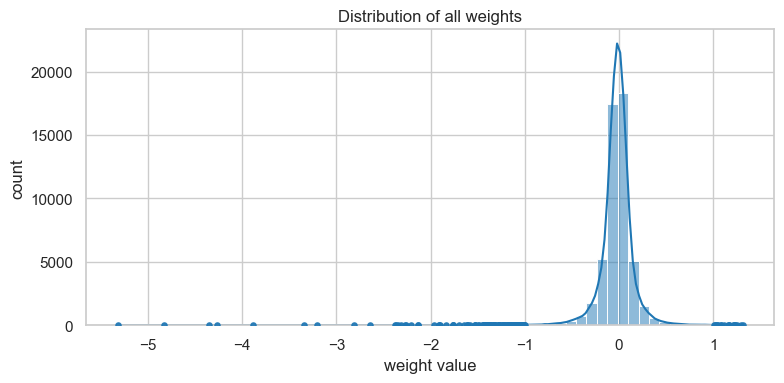

In [30]:
all_weights = []
per_layer_weights = []

for layer in model.layers:
    w = layer.get_weights()
    if not w:
        continue
    flat = np.concatenate([x.ravel() for x in w])
    all_weights.append(flat)
    per_layer_weights.append({
        "layer": layer.name,
        "count": flat.size,
        "mean": float(np.mean(flat)),
        "std": float(np.std(flat)),
        "min": float(np.min(flat)),
        "max": float(np.max(flat))
    })

all_weights_flat = np.concatenate(all_weights)
weights_stats_df = pd.DataFrame(per_layer_weights).sort_values("count", ascending=False)
print("Per-layer weights statistics:")
display(HTML(weights_stats_df.to_html(index=False)))

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8,4))
sns.histplot(all_weights_flat, bins=60, kde=True, color="tab:blue")
extreme_mask = (all_weights_flat < -1) | (all_weights_flat > 1)
extreme_vals = all_weights_flat[extreme_mask]
plt.scatter(extreme_vals, np.zeros_like(extreme_vals),
            s=14, color="tab:blue", marker="o", alpha=0.9, zorder=3)
plt.title("Distribution of all weights")
plt.xlabel("weight value")
plt.ylabel("count")
plt.tight_layout()
plt.show()

##### Neurons and Parameters per Layer

The dense layers contain 512, 64, and 3 neurons respectively, narrowing toward the 3‑class softmax output.

Trainable parameters per layer: dense_1 holds the largest share (32832), followed by dense (18944) and the output dense_2 (195). Dropout layers have zero parameters, so capacity is concentrated in the hidden Dense layers.

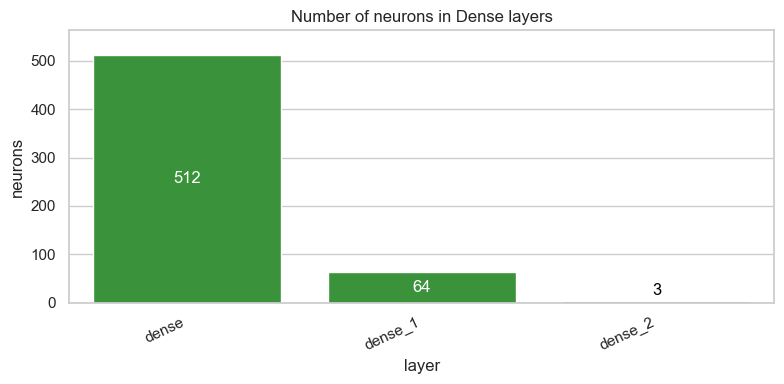

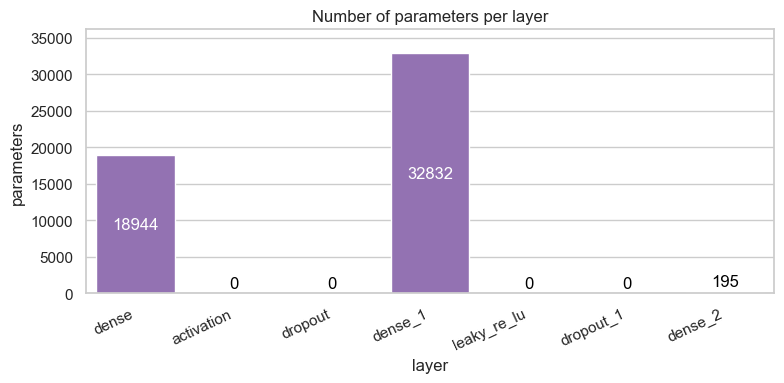

In [20]:
dense_mask = layers_df["type"].eq("Dense")

plt.figure(figsize=(8,4))
ax = sns.barplot(x=layers_df.loc[dense_mask,"name"], y=layers_df.loc[dense_mask,"neurons"], color="tab:green")
plt.title("Number of neurons in Dense layers")
plt.xlabel("layer")
plt.ylabel("neurons")
plt.xticks(rotation=25, ha="right")

bars = ax.containers[0]
heights = np.array([b.get_height() for b in bars], dtype=float)
thr = 0.08 * (ax.get_ylim()[1] - ax.get_ylim()[0])
ax.margins(y=0.1)
ax.bar_label(bars, labels=[f"{v:.0f}" if v >= thr else "" for v in heights], label_type="center", color="white")
ax.bar_label(bars, labels=[f"{v:.0f}" if v <  thr else "" for v in heights],  label_type="edge",   padding=2, color="black")

plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
ax = sns.barplot(x=layers_df["name"], y=layers_df["params"], color="tab:purple")
plt.title("Number of parameters per layer")
plt.xlabel("layer")
plt.ylabel("parameters")
plt.xticks(rotation=25, ha="right")

bars = ax.containers[0]
heights = np.array([b.get_height() for b in bars], dtype=float)
thr = 0.08 * (ax.get_ylim()[1] - ax.get_ylim()[0])
ax.margins(y=0.1)
ax.bar_label(bars, labels=[f"{v:.0f}" if v >= thr else "" for v in heights], label_type="center", color="white")
ax.bar_label(bars, labels=[f"{v:.0f}" if v <  thr else "" for v in heights],  label_type="edge",   padding=2, color="black")

plt.tight_layout()
plt.show()

##### Test Set Metrics

The model was optimized using macro AUC (One-vs-Rest) as the primary objective, ensuring balanced performance across all three classes. On the test set, the network reaches a macro AUC of 0.8814, indicating strong separability. The accuracy of 0.7446 shows a clear improvement in overall multi-class prediction quality. Macro precision (0.7859), macro recall (0.7362), and macro F1 (0.7531) reflect a reasonably balanced trade-off between identifying each class and limiting false positives.

Weighted metrics (precision 0.7567, recall 0.7446, F1 0.7448) are close to the macro values, suggesting that performance remains stable after accounting for class frequency. The test loss is 0.6071, consistent with a well‑regularized model. 

Overall, results indicate good generalization and balanced treatment of all classes.

In [21]:
y_test_int = np.asarray(y_test, dtype=np.int32)
sample = model.predict(X_test, verbose=0)
y_pred = np.argmax(sample, axis=1)

acc = accuracy_score(y_test_int, y_pred)
auc_macro = roc_auc_score(y_test_int, sample, multi_class="ovr", average="macro")
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(y_test_int, y_pred, average="macro", zero_division=0)
prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(y_test_int, y_pred, average="weighted", zero_division=0)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
loss = float(loss_fn(y_test_int, sample).numpy())

print("Metrics (Test):")
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"AUC macro (OVR): {auc_macro:.4f}")
print(f"Precision macro: {prec_macro:.4f} | Recall macro: {rec_macro:.4f} | F1 macro: {f1_macro:.4f}")
print(f"Precision weighted: {prec_weighted:.4f} | Recall weighted: {rec_weighted:.4f} | F1 weighted: {f1_weighted:.4f}")

Metrics (Test):
Loss: 0.6071
Accuracy: 0.7446
AUC macro (OVR): 0.8814
Precision macro: 0.7859 | Recall macro: 0.7362 | F1 macro: 0.7531
Precision weighted: 0.7567 | Recall weighted: 0.7446 | F1 weighted: 0.7448


##### Per-class Report

Class 0 (good) shows balanced performance, with precision (0.7148) and higher recall (0.8354), indicating the model captures most true good cases while some additional false positives reduce precision; F1 is 0.7704.

Class 1 (undefined) has similar precision (0.7040) and recall (0.6828), reflecting moderate difficulty and class overlap; the F1-score is 0.6933.

Class 2 (bad) achieves very high precision (0.9388) with moderate recall (0.6905), meaning predictions for this class are highly reliable but some true bad cases are missed; F1 is 0.7957. 

Overall, each class shows a distinct precision–recall trade‑off, reflecting differing separation difficulty.

Per-class metrics:


class,precision,recall,f1,support
0,0.7148,0.8354,0.7704,1446
1,0.7040,0.6828,0.6933,1463
2,0.9388,0.6905,0.7957,756


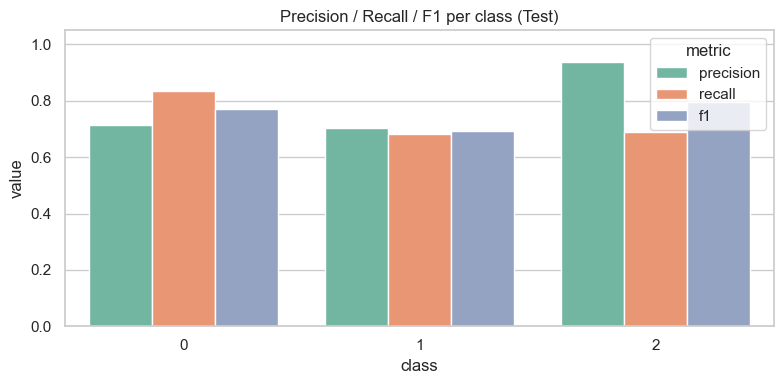

In [22]:
labels = [0,1,2]
prec_c, rec_c, f1_c, sup_c = precision_recall_fscore_support(y_test_int, y_pred, labels=labels, zero_division=0)

per_class_df = pd.DataFrame({
    "class": labels,
    "precision": np.round(prec_c,4),
    "recall": np.round(rec_c,4),
    "f1": np.round(f1_c,4),
    "support": sup_c.astype(int)
})
print("Per-class metrics:")
display(HTML(per_class_df.to_html(index=False)))

melted = per_class_df.melt(id_vars="class", value_vars=["precision","recall","f1"], var_name="metric", value_name="value")
plt.figure(figsize=(8,4))
sns.barplot(data=melted, x="class", y="value", hue="metric", palette="Set2")
plt.ylim(0,1.05)
plt.title("Precision / Recall / F1 per class (Test)")
plt.xlabel("class")
plt.ylabel("value")
plt.tight_layout()
plt.show()

##### Confusion Matrix

The confusion matrix indicates 2729 correct predictions (1208 for class 0, 999 for class 1, and 522 for class 2), yielding an overall accuracy of approximately 74.5% (2729/3665). Class-wise recall is 0.835 for class 0 (1208/1446), 0.683 for class 1 (999/1463), and 0.691 for class 2 (522/756). Precision by predicted class is 0.715 for class 0 (1208/1690), 0.704 for class 1 (999/1419), and 0.939 for class 2 (522/556).

The most frequent misclassifications are true 1 predicted as 0 (433), true 0 predicted as 1 (235), and true 2 predicted as 1 (185). Confusions between classes 0 and 2 remain rare (0 to 2: 3; 2 to 0: 49), confirming that most errors involve class 1 as the intermediate category.

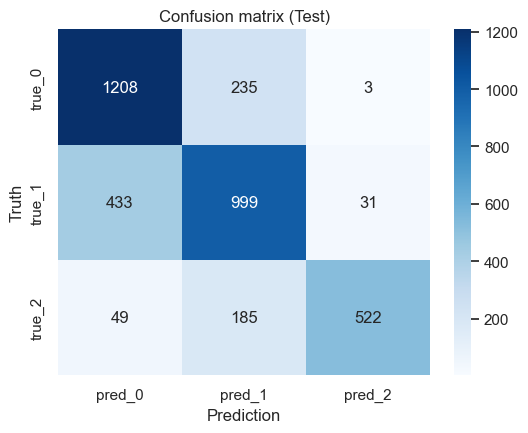

In [23]:
cm = confusion_matrix(y_test_int, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=[f"true_{c}" for c in labels], columns=[f"pred_{c}" for c in labels])

plt.figure(figsize=(5.5,4.5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion matrix (Test)")
plt.xlabel("Prediction")
plt.ylabel("Truth")
plt.tight_layout()
plt.show()

##### ROC and AUC

Vialization of the optimization metric.

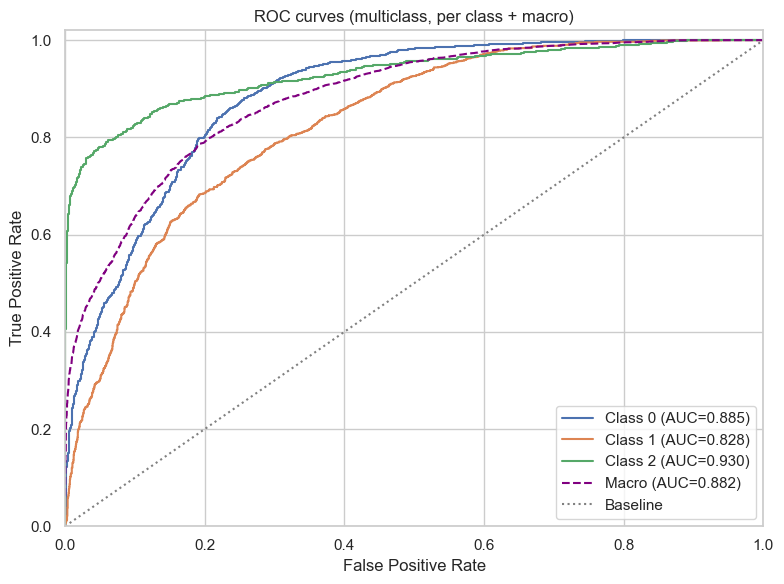

AUC per class: {0: 0.8855, 1: 0.8285, 2: 0.9302}
AUC macro: 0.8816


In [24]:
classes = [0, 1, 2]

y_test_int = np.asarray(y_test, dtype=np.int32)
y_test_bin = label_binarize(y_test_int, classes=classes)

fpr, tpr, roc_auc = {}, {}, {}

for i, c in enumerate(classes):
    fpr[c], tpr[c], _ = roc_curve(y_test_bin[:, i], sample[:, i])
    roc_auc[c] = auc(fpr[c], tpr[c])

all_fpr = np.unique(np.concatenate([fpr[c] for c in classes]))
mean_tpr = np.zeros_like(all_fpr)
for c in classes:
    mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])
mean_tpr /= len(classes)
roc_auc["macro"] = auc(all_fpr, mean_tpr)

plt.figure(figsize=(8, 6))
for c in classes:
    plt.plot(fpr[c], tpr[c], label=f'Class {c} (AUC={roc_auc[c]:.3f})')
plt.plot(all_fpr, mean_tpr, linestyle='--', color='purple', label=f'Macro (AUC={roc_auc["macro"]:.3f})')
plt.plot([0,1],[0,1], color='grey', linestyle=':', label='Baseline')
plt.xlim([0,1]); plt.ylim([0,1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves (multiclass, per class + macro)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

print("AUC per class:", {c: round(roc_auc[c],4) for c in classes})
print("AUC macro:", round(roc_auc["macro"],4))

#### Interpretability

In this section, we aim to shed light on the model’s decision-making process in order to better understand how it operates and why it produces specific predictions. 

By exploring interpretability techniques, we can identify which features influence the model the most, uncover potential biases, and evaluate whether the learned patterns align with domain knowledge. This not only increases transparency but also helps validate the reliability and trustworthiness of the model’s outputs.

##### Class Selection Propability

The graph presents the model’s predicted class probabilities for a single test instance. These values are the softmax outputs and therefore sum to one, expressing the model’s assessed likelihood for each class.

In this case, the highest probability is assigned to the "undefined" class (0.49), followed by "good" (0.43) and "bad" (0.08); under the standard argmax rule the instance is classified as "undefined".

The 0.06 gap between the top two classes indicates only moderate confidence and a possible flip between undefined and good, while the very low bad probability (0.08) likely reflects that this instance’s feature pattern resembles borderline good/undefined profiles. The model is cautious when assigning a client to the bad class.

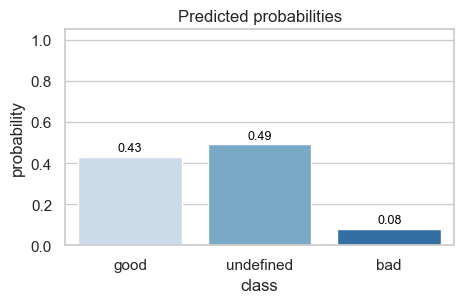

In [25]:
class_names = ["good", "undefined", "bad"]

feature_names = list(X_train.columns)
cat_cols_present = [c for c in categorical_cols if c in feature_names]
categorical_features_idx = [feature_names.index(c) for c in cat_cols_present]

def predict_sample_fn(x):
    X_df = pd.DataFrame(x, columns=feature_names)
    return model.predict(X_df, verbose=0)

explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=feature_names,
    class_names=class_names,
    categorical_features=categorical_features_idx if categorical_features_idx else None,
    mode="classification",
    discretize_continuous=True
)

idx = 0
x = X_test.iloc[idx].values

explanation = explainer.explain_instance(
    data_row=x,
    predict_fn=predict_sample_fn,
    num_features=len(feature_names),
    top_labels=len(class_names)
)

as_map = explanation.as_map()

sample = predict_sample_fn([x])[0]
plt.figure(figsize=(4.8, 3.2))
ax = sns.barplot(x=class_names, y=sample, hue=class_names, palette="Blues", legend=False)
plt.ylim(0, 1.05)
plt.title("Predicted probabilities")
plt.ylabel("probability"); plt.xlabel("class")

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=2, fontsize=9, color="black")

plt.tight_layout(); plt.show()

##### Features Contribution by Class

LIME attributes the class scores to a small set of features. For class "good", the strongest positive contributions come from SUMA_NAL_WYMAGAL_NRAT, SUMA_NAL_WYMAGAL_KARTY and MAX_NAL_WYMAGAL, with ILE_BANKOW adding a smaller positive effect, while MAX_WNIOSKODAWCY and ILE_RACH_ODNAWIALNE provide a small negative contribution. 

For class "undefined", SUMA_DO_SPLATY_ODNAWIALNE, MAX_NAL_WYMAGAL, POWIAT AND SUMA_NAL_WYMAGAL_KARTY contribute positively, whereas location/count features such as GMINA and ILE_BANKOW contribute negatively. SUMA_NAL_WYMAGAL_NRAT shows a strong negative contribution.

For class "bad", the overdue-amount variables (SUMA_NAL_WYMAGAL_KARTY and MAX_NAL_WYMAGAL) strongly decrease the score, while GMINA and SUMA_DO_SPLATY_KARTY increase it slightly. We can also observe moderate negative impacts from SUMA_DO_SPLATY_ODNAWIALNE and POWIAT.

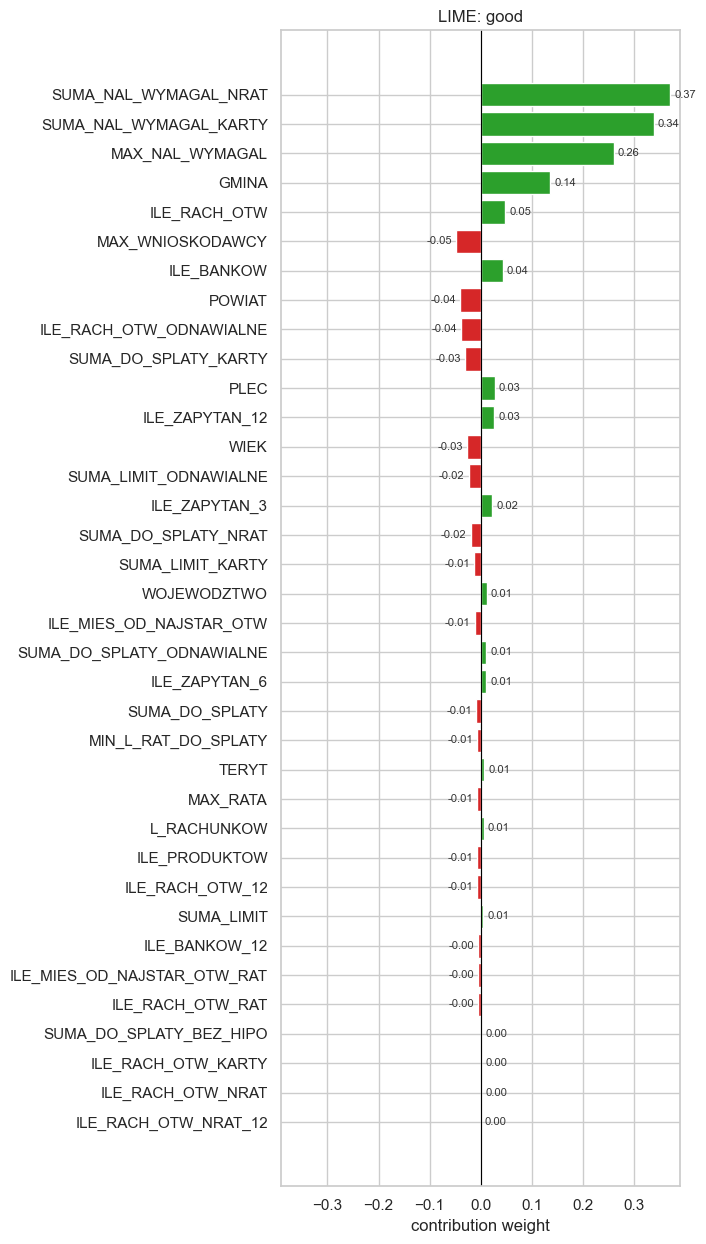

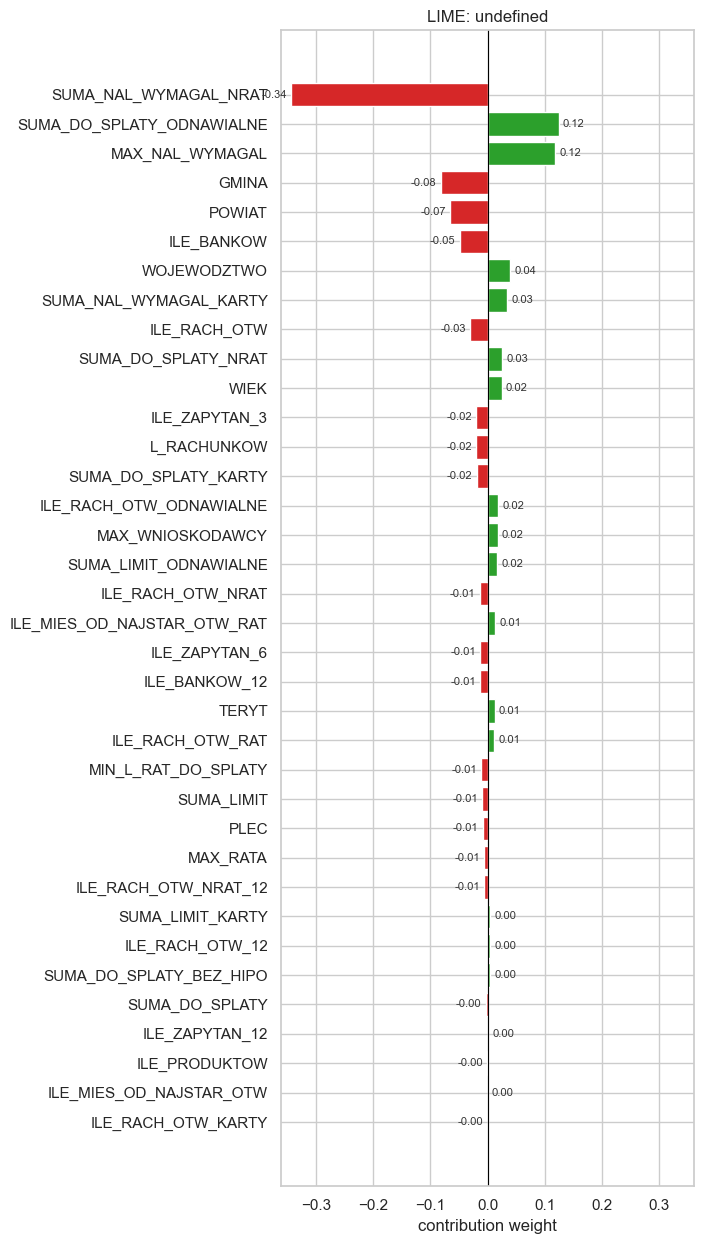

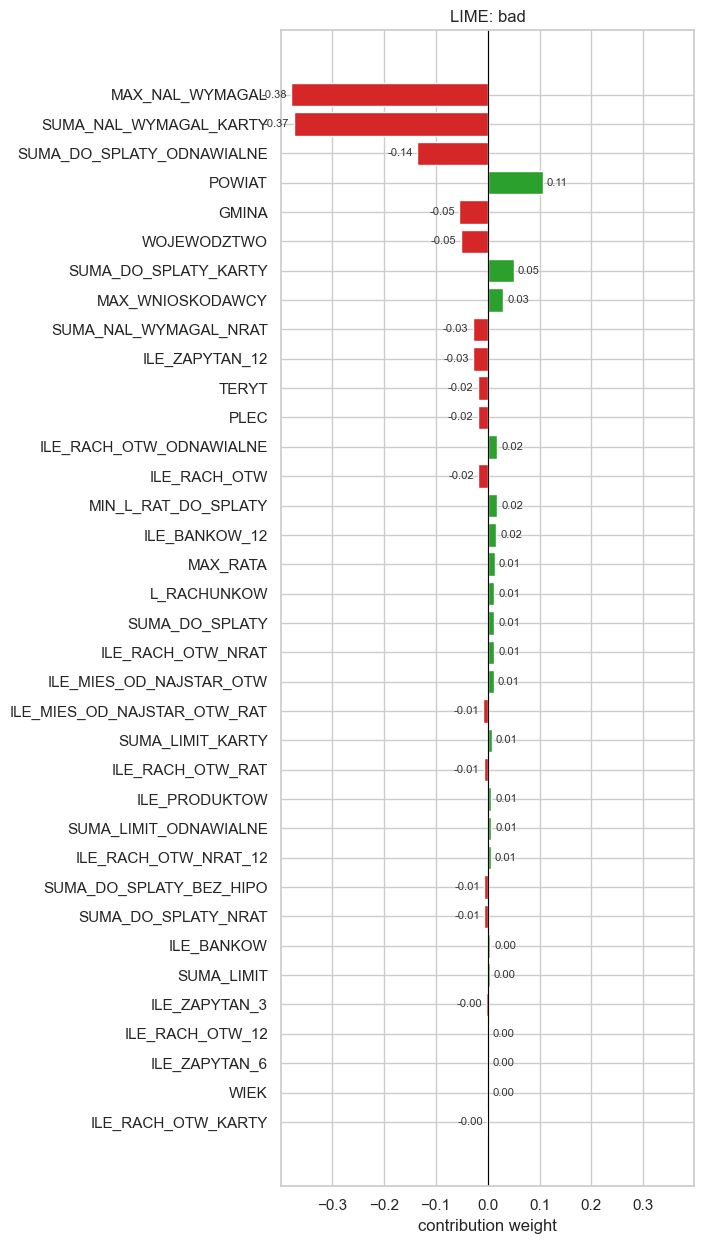

In [32]:
plots_data = []
for lbl in classes:
    contrib = as_map[lbl]
    feat_idx = [i for i, _ in contrib]
    weights = np.array([w for _, w in contrib], dtype=float)
    feat_labels = [feature_names[i] for i in feat_idx]

    order = np.argsort(np.abs(weights))[::-1]
    w_sorted = weights[order]
    f_sorted = [feat_labels[i] for i in order]
    colors = ["#2ca02c" if w > 0 else "#d62728" for w in w_sorted]

    plots_data.append({"lbl": lbl, "w": w_sorted, "f": f_sorted, "colors": colors})

for d in plots_data:
    x_abs_max = float(np.max(np.abs(d["w"]))) * 1.05
    n = len(d["f"])
    h = max(3.5, 0.35 * n)

    plt.figure(figsize=(7.2, h))
    ax = plt.gca()
    bars = ax.barh(d["f"], d["w"], color=d["colors"])
    ax.invert_yaxis()
    ax.axvline(0, color="black", linewidth=0.8)
    ax.set_title(f"LIME: {class_names[d['lbl']]}")
    ax.set_xlabel("contribution weight")
    ax.set_xlim(-x_abs_max, x_abs_max)

    x_min, x_max = ax.get_xlim()
    pad = 0.01 * (x_max - x_min)
    for bar, w in zip(bars, d["w"]):
        x_text = w + (pad if w >= 0 else -pad)
        ha = "left" if w >= 0 else "right"
        ax.text(x_text, bar.get_y() + bar.get_height() / 2, f"{w:.2f}",
                va="center", ha=ha, fontsize=8, color="#333")

    plt.tight_layout()
    plt.show()

##### Global Feature Importance

The chart shows permutation importance on the validation set. Shuffling MAX_NAL_WYMAGAL yields the largest accuracy drop (0.192), then SUMA_NAL_WYMAGAL_NRAT (0.065), SUMA_NAL_WYMAGAL_KARTY (0.046), and ILE_MIES_OD_NAJSTAR_OTW_RAT (0.019). Subsequent features have smaller but still measurable impact: SUMA_DO_SPLATY_ODNAWIALNE (0.014), SUMA_DO_SPLATY (0.013), ILE_RACH_OTW (0.012), ILE_BANKOW (0.011), MIN_L_RAT_DO_SPLATY (0.010), MAX_WNIOSKODAWCY (0.008), GMINA (0.007), SUMA_DO_SPLATY_BEZ_HIPO (0.007), ILE_ZAPYTAN_12 (0.006), POWIAT (0.006) and ILE_RACH_OTW_ODNAWIALNE (0.004). Baseline accuracy is 0.717; larger deltas indicate stronger global dependence.

Feature contribution by class (LIME) is local and class‑specific: it explains one instance, shows direction (positive/negative) and magnitude for each class score. Global permutation importance is dataset‑level and class‑agnostic: it measures how much shuffling a feature degrades overall accuracy, provides magnitude only, and does not indicate sign or instance‑level effects.

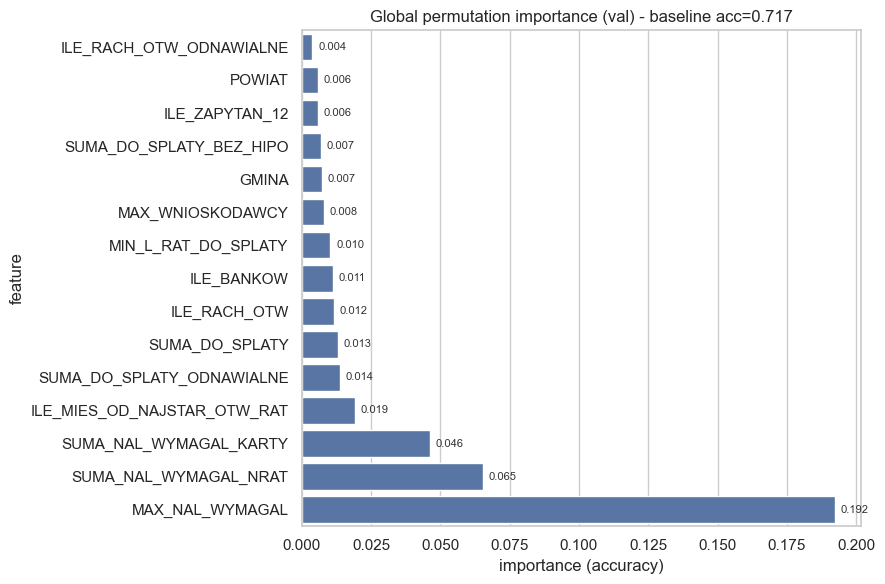

In [27]:
y_val_int = np.asarray(y_val, dtype=np.int32)

def _predict_sample_df(X: pd.DataFrame):
    return model.predict(X, verbose=0)

def _predict_label_df(X: pd.DataFrame):
    return np.argmax(_predict_sample_df(X), axis=1)

baseline_acc = accuracy_score(y_val_int, _predict_label_df(X_val))
rng = np.random.RandomState(42)
importances = {}
Xv = X_val.copy()
N_REPEATS = 5

for col in Xv.columns:
    scores = []
    orig = Xv[col].values.copy()
    for _ in range(N_REPEATS):
        Xv[col] = rng.permutation(orig)
        acc = accuracy_score(y_val_int, _predict_label_df(Xv))
        scores.append(acc)
    Xv[col] = orig
    importances[col] = baseline_acc - float(np.mean(scores))

fi = pd.Series(importances).sort_values(ascending=False)

TOP_K_FI = 15
plt.figure(figsize=(9, 6))
top_fi = fi.head(TOP_K_FI)[::-1]
ax = sns.barplot(x=top_fi.values, y=top_fi.index, color="C0")
ax.set_title(f"Global permutation importance (val) - baseline acc={baseline_acc:.3f}")
ax.set_xlabel("importance (accuracy)")
ax.set_ylabel("feature")
for bar, v in zip(ax.patches, top_fi.values):
    ax.text(bar.get_width() + 0.002, bar.get_y() + bar.get_height()/2, f"{v:.3f}",
            va="center", ha="left", fontsize=8, color="#333")
plt.tight_layout()
plt.show()

##### Partial Depencence (class 2)

Partial dependence shows the marginal effect of a feature on the model output: for each value on the x‑axis, the model’s predictions are averaged over the validation set while only that feature is varied and all others stay at their observed values. The y‑axis is the mean predicted probability of class 2 ("bad").

In the figure, MAX_NAL_WYMAGAL and SUMA_NAL_WYMAGAL_NRAT show strong monotonic increases (MAX_NAL_WYMAGAL saturates very early near 1.0). SUMA_NAL_WYMAGAL_KARTY climbs rapidly then flattens. ILE_MIES_OD_NAJSTAR_OTW_RAT and SUMA_DO_SPLATY_ODNAWIALNE have modest positive slopes. SUMA_DO_SPLATY decreases steadily (protective effect). Curves are computed over the 1st–99th percentile ranges and should be interpreted with the usual PDP assumption of weak feature dependence.

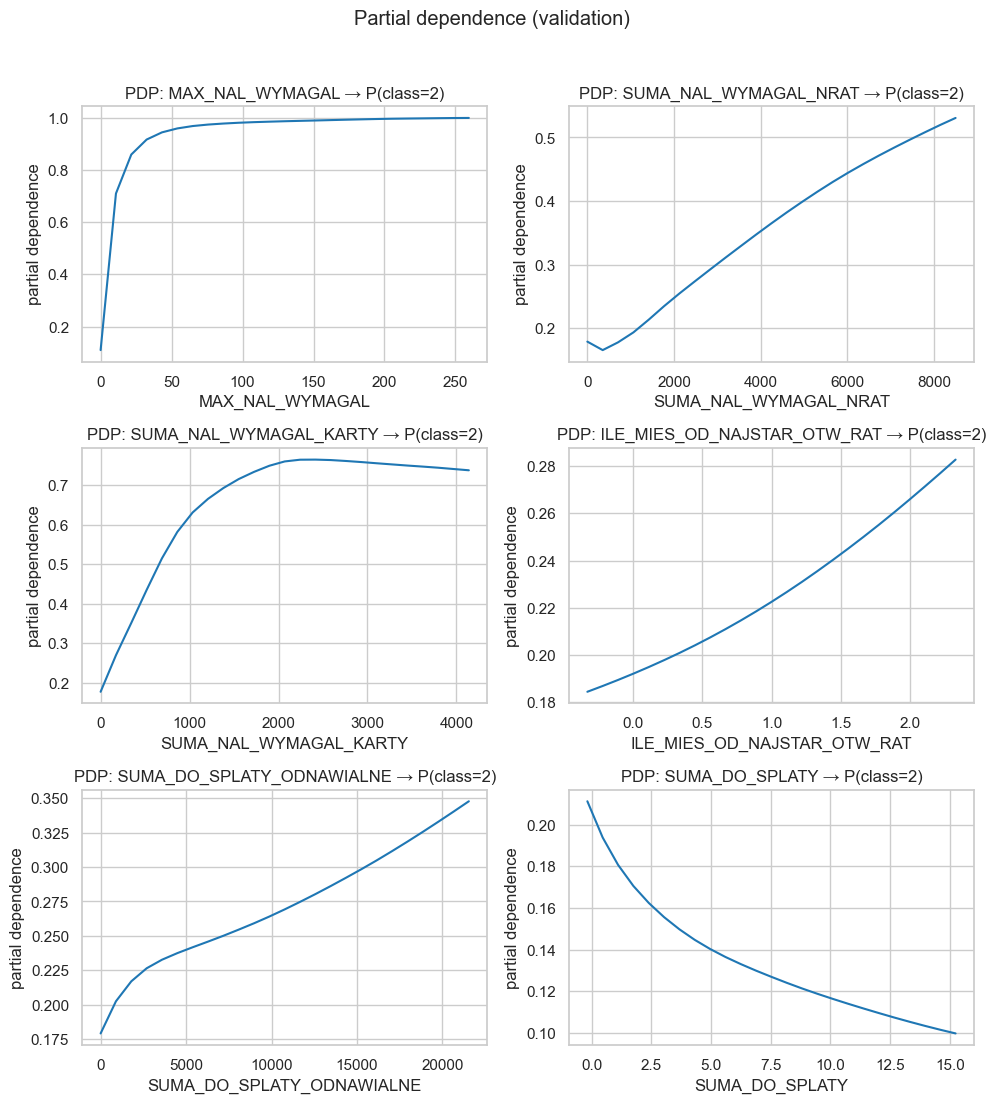

In [31]:
PDP_TOP = 6
PDP_TARGET_CLASS = 2  # 0=good, 1=undefined, 2=bad
features_pdp = fi.head(PDP_TOP).index.tolist()

ncols, nrows = 2, 3
nplots = len(features_pdp)
fig, axes = plt.subplots(nrows, ncols, figsize=(5.0 * ncols, 3.6 * nrows), sharey=False)
axes = np.array(axes).ravel()

for i, feat in enumerate(features_pdp):
    ax = axes[i]
    x_min = float(np.nanpercentile(X_val[feat], 1))
    x_max = float(np.nanpercentile(X_val[feat], 99))
    grid = np.linspace(x_min, x_max, 25)

    vals = []
    X_tmp = X_val.copy()
    for v in grid:
        X_tmp[feat] = v
        sample = _predict_sample_df(X_tmp)
        vals.append(float(sample[:, PDP_TARGET_CLASS].mean()))

    ax.plot(grid, vals, color="tab:blue")
    ax.set_title(f"PDP: {feat} → P(class={PDP_TARGET_CLASS})")
    ax.set_xlabel(feat)
    ax.set_ylabel("partial dependence")

for j in range(nplots, nrows * ncols):
    axes[j].set_visible(False)

fig.suptitle("Partial dependence (validation)", y=1.02)
plt.tight_layout()
plt.show()

#### Additional Information
<a id='additional_information'></a>

##### Optuna search

The Optuna study optimizes a feed‑forward neural network on 36 preprocessed features without class weighting. It runs 120 trials, maximizing validation macro AUC (OVR). Each trial builds 1–3 Dense layers (units (64,128,256,512), activation (relu, leaky_relu), optional dropout 0.0–0.5) followed by a 3‑unit softmax output. Adam learning rate is sampled log‑uniformly in [1e‑4, 1e‑2]; batch size (32,64,128). Training per trial: up to 50 epochs with EarlyStopping on val_loss (patience 6, restore best weights). The best configuration is rebuilt and retrained for up to 60 epochs (patience 8) then saved as best_credit_scoring_model_optuna_auc.h5. Reproducibility is enforced with tf.random.set_seed(42). Final evaluation reports macro/weighted precision, recall, F1, accuracy, macro AUC, and the confusion matrix.

In [ ]:
tf.random.set_seed(42)

NUM_CLASSES = 3
input_dim = X_train.shape[1]

y_train_int = np.asarray(y_train, dtype=np.int32)
y_val_int = np.asarray(y_val, dtype=np.int32)
y_test_int = np.asarray(y_test, dtype=np.int32)

def build_model_from_trial(trial):
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(Input(shape=(input_dim,)))

    layers = trial.suggest_int("layers", 1, 3)
    for i in range(layers):
        units = trial.suggest_categorical(f"units_{i+1}", [64, 128, 256, 512])
        act = trial.suggest_categorical(f"activation_{i+1}", ["relu", "leaky_relu"])
        model.add(Dense(units))
        if act == "relu":
            model.add(Activation("relu"))
        else:
            model.add(LeakyReLU(alpha=0.1))
        dr = trial.suggest_float(f"dropout_{i+1}", 0.0, 0.5)
        if dr > 0:
            model.add(Dropout(dr))

    model.add(Dense(NUM_CLASSES, activation="softmax"))

    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

def objective(trial):
    model = build_model_from_trial(trial)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    es = EarlyStopping(monitor="val_loss", patience=6, mode="min", restore_best_weights=True, verbose=0)

    history = model.fit(
        X_train, y_train_int,
        validation_data=(X_val, y_val_int),
        epochs=50,
        batch_size=batch_size,
        callbacks=[es],
        verbose=0
    )

    # Evaluate by macro AUC on validation
    proba_val = model.predict(X_val, verbose=0)
    auc_macro = roc_auc_score(y_val_int, proba_val, multi_class="ovr", average="macro")
    return auc_macro

study = optuna.create_study(direction="maximize", study_name="nn_credit_scoring_optuna")
N_TRIALS = 120
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print("Best trial AUC (val):", study.best_value)
print("Best params:", study.best_trial.params)

# Rebuild, retrain best model
best_params = study.best_trial.params
def rebuild_best(params):
    class DummyTrial:
        def __init__(self, p): self.p = p
        def suggest_int(self, name, a, b): return self.p[name]
        def suggest_categorical(self, name, choices): return self.p[name]
        def suggest_float(self, name, a, b, log=False): return self.p[name]
    return build_model_from_trial(DummyTrial(params))

optuna_best_model = rebuild_best(best_params)
es = EarlyStopping(monitor="val_loss", patience=8, mode="min", restore_best_weights=True, verbose=1)
history_best = optuna_best_model.fit(
    X_train, y_train_int,
    validation_data=(X_val, y_val_int),
    epochs=60,
    batch_size=best_params.get("batch_size", 64),
    callbacks=[es],
    verbose=2
)
optuna_best_model.save("best_credit_scoring_model_optuna_auc2.h5")

def eval_split_opt(name, model, X, y_true):
    sample = model.predict(X, verbose=0)
    y_pred = np.argmax(sample, axis=1)

    auc_macro = roc_auc_score(y_true, sample, multi_class='ovr', average='macro')
    prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    acc = accuracy_score(y_true, y_pred)

    print(f"\n== {name} ==")
    print(f"AUC macro (OVR): {auc_macro:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision macro: {prec_macro:.4f} | Recall macro: {rec_macro:.4f} | F1 macro: {f1_macro:.4f}")
    print(f"Precision weighted: {prec_weighted:.4f} | Recall weighted: {rec_weighted:.4f} | F1 weighted: {f1_weighted:.4f}")
    print("\nClassification report:\n", classification_report(y_true, y_pred, digits=4))

    labels = [0, 1, 2]  # 0=good, 1=undefined, 2=bad
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    print("Confusion matrix (rows=true, cols=pred):")
    print(pd.DataFrame(cm, index=labels, columns=labels))